In [1]:
import numpy as np
#import gplately.pygplates as pygplates
import ptt
import gplately
import gplately.tools as tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
import glob, os
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import matplotlib.gridspec as gridspec
#from slabdip import SlabDipper
import matplotlib
import pandas as pd
from cmcrameri import cm
#import gplately.pygplates as pygplates
import glob, os
import matplotlib.pyplot as plt
from plate_model_manager import PlateModelManager

from gplately import pygplates

import geopandas as gpd

# matplotlib.rcParams['font.family'] = 'Arial'
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams.update({
#     "pdf.use14corefonts": True
# })

reconstruction_times = np.arange(0,1800,1)
extent_global = [-180,180,-90,90]


##################################################################################################

            You are using a DEV version (1.3.0.post140+git.22c934e6) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
#################

# Import 1.8Ga_model_optimised_mantle_ref_frame_20240725

In [2]:
use_local_files = True

if use_local_files:
    # Method 1: manually point to files
    input_directory = '1.8Ga_model_optimised_mantle_ref_frame_20240725/1.8Ga_model_optimised_mantle_ref_frame_20240725'
    # Load rotation files
    rotation_filenames = glob.glob(os.path.join(input_directory, 'optimised_rotation_model_20240725_run3.rot'))
    rotation_model = pygplates.RotationModel(rotation_filenames)

    # Load static polygons
    static_polygons = pygplates.FeatureCollection(os.path.join(input_directory, 'static_polygons.gpmlz'))
    COBs = input_directory+'/COBfile_1800_0.gpml'
    # Load topology files and combine into a single FeatureCollection
    topology_filenames = [
        os.path.join(input_directory, '250-0_plate_boundaries.gpml'),
        os.path.join(input_directory, '410-250_plate_boundaries.gpml'),
        os.path.join(input_directory, '1800-1000_plate_boundaries.gpml'),
        os.path.join(input_directory, '1000-410_plate_boundaries.gpml'),
        os.path.join(input_directory, '1000-410-Convergence.gpml'),
        os.path.join(input_directory, '1000-410-Divergence.gpml'),
        #os.path.join(input_directory, '1000-410-Topologies.gpml'),
        os.path.join(input_directory, '1000-410-Transforms.gpml'),
        os.path.join(input_directory, 'TopologyBuildingBlocks.gpml'),
    ]
    
    # Create an empty list to hold all the features
    all_topology_features = []

    # Load each file and append its features to the list
    for topology_filename in topology_filenames:
        fc = pygplates.FeatureCollection(topology_filename)
        all_topology_features.extend(fc)

    # Create a single FeatureCollection from the combined features
    topology_features = pygplates.FeatureCollection(all_topology_features)

    # Optionally load other geological features if needed
    continents = pygplates.FeatureCollection(os.path.join(input_directory, 'shapes_continents.gpmlz'))
    COBs = pygplates.FeatureCollection(os.path.join(input_directory, 'COBfile_1800_0.gpml'))
    #Paleomagnetic_poles = pygplates.FeatureCollection(os.path.join(input_directory, 'Paleomagnetic_poles.gpml'))
    shapes_coasts = pygplates.FeatureCollection(os.path.join(input_directory, 'shapes_coasts.gpmlz'))
    #deposits = pygplates.FeatureCollection('/data/Craton_HS_2B_PLATEID1/Craton_Deposits_PLATEID1.gpml')

    # Create PlateReconstruction model
    model = gplately.PlateReconstruction(rotation_model=rotation_model, 
                                     topology_features=topology_features, 
                                     static_polygons=static_polygons)

    # Now you can proceed with your reconstruction and plotting...


C:\Users\Hojat\.conda\envs\gplately\lib\site-packages\gplately\pygplates.py:347: ImportWarning: 
FeatureCollection: No filename associated with <class 'list'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates


# Load Hoggard data

In [3]:
#shp

In [11]:
import geopandas as gpd
import pandas as pd
import gplately

# Read the shapefile into a GeoDataFrame
gdf = gpd.read_file('./Inputs/Deposits_SpatialRelationships.shp')  # Replace with the actual path to your shapefile

# Dictionary to hold DataFrames for each type
metal_dict = dict()

# List of commodities (not used in the filtering, just for reference)
commodities = ['Cu (Mt)', 'Pb (Mt)', 'Zn (Mt)', 'Ni (Mt)']

# Get unique types from the 'Type' column
types = gdf['Type'].unique()

# Filter data by type
for type_name in types:
    df = gdf[gdf['Type'] == type_name]
    
    # Ensure that the 'Age' column is present and filter data
    if 'Age' in df.columns:
        df = df[df['Age'].notna()]
        df = df[df['Age'] > 0]  # Remove rows where Age = 0
        df = df[df['Age'] <= 1800]
        
        if df.shape[0] > 0:
            metal_dict[type_name] = df

# Process the filtered data
pts_dict = dict()
for i, t in enumerate(types):
    df = metal_dict[t]
    
    # Extract Lon/Lat from the geometry column and create points for gplately
    pts_dict[t] = gplately.Points(model, df['geometry'].x, df['geometry'].y)

# You can now proceed with the rest of your code (e.g., plotting symbols)
symbols = ['o', 'v', 's', '*', 'd', '^', 'P']*2


## Histograms (Age)

### Histograms (Age) (No.)

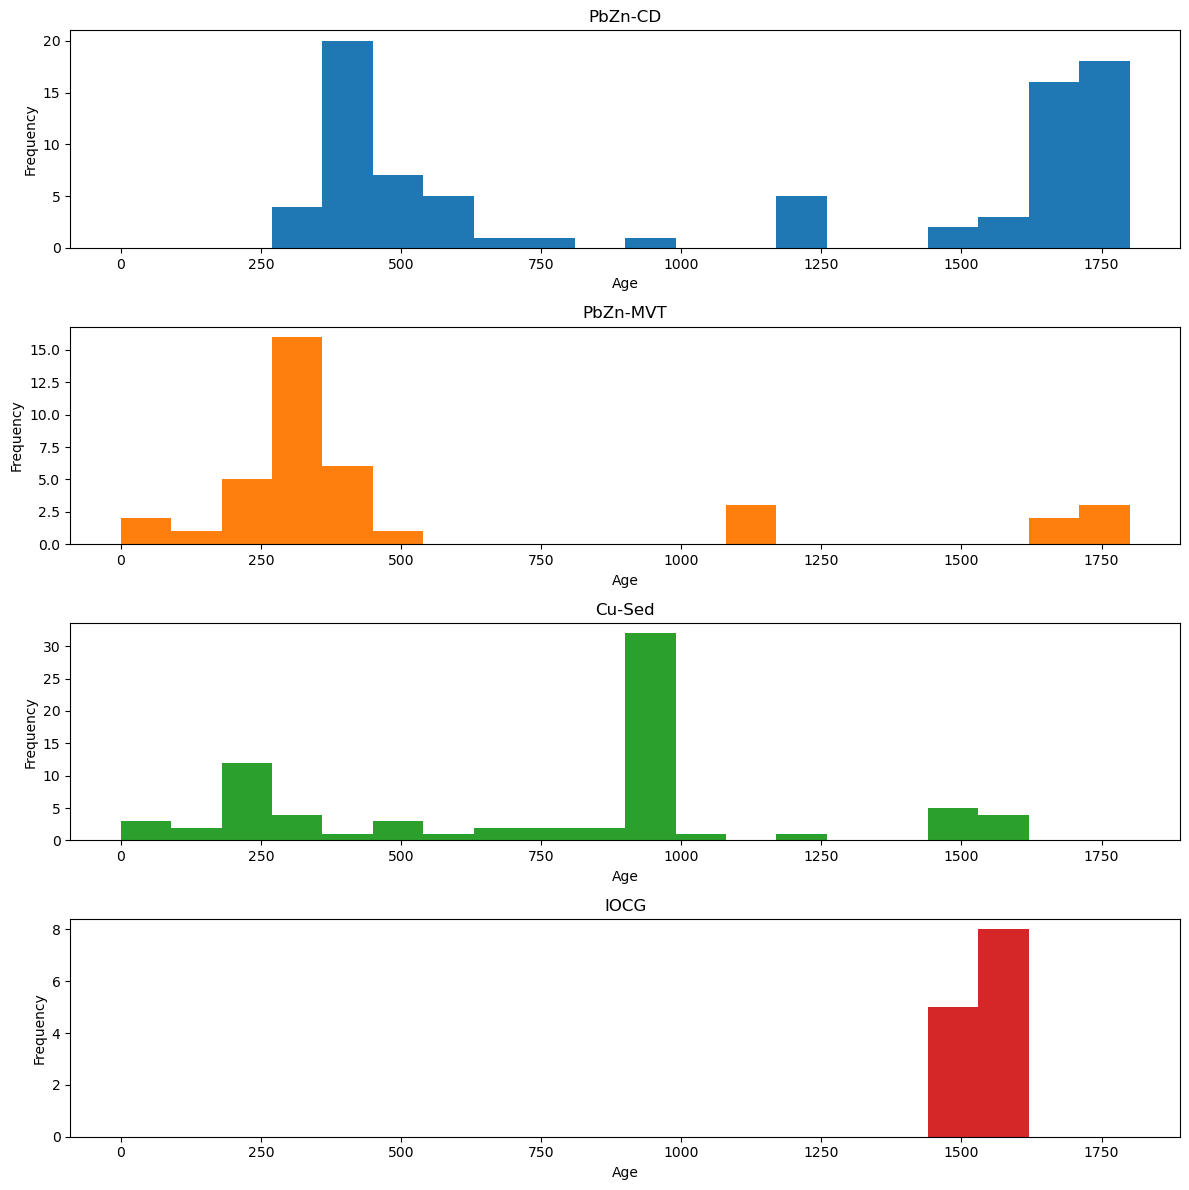

In [69]:
import matplotlib.pyplot as plt

# Create histograms for each mineral type
fig, axes = plt.subplots(len(types), 1, figsize=(12, 12))

# Plot histograms for each type in 'Type' column
for i, type_name in enumerate(types):
    df = metal_dict[type_name]

    axes[i].hist(df['Age'], range=(0, 1800), bins=20, color='C{}'.format(i))  # Convert Ga to Ma
    axes[i].set_title(type_name)
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Weighted histograms

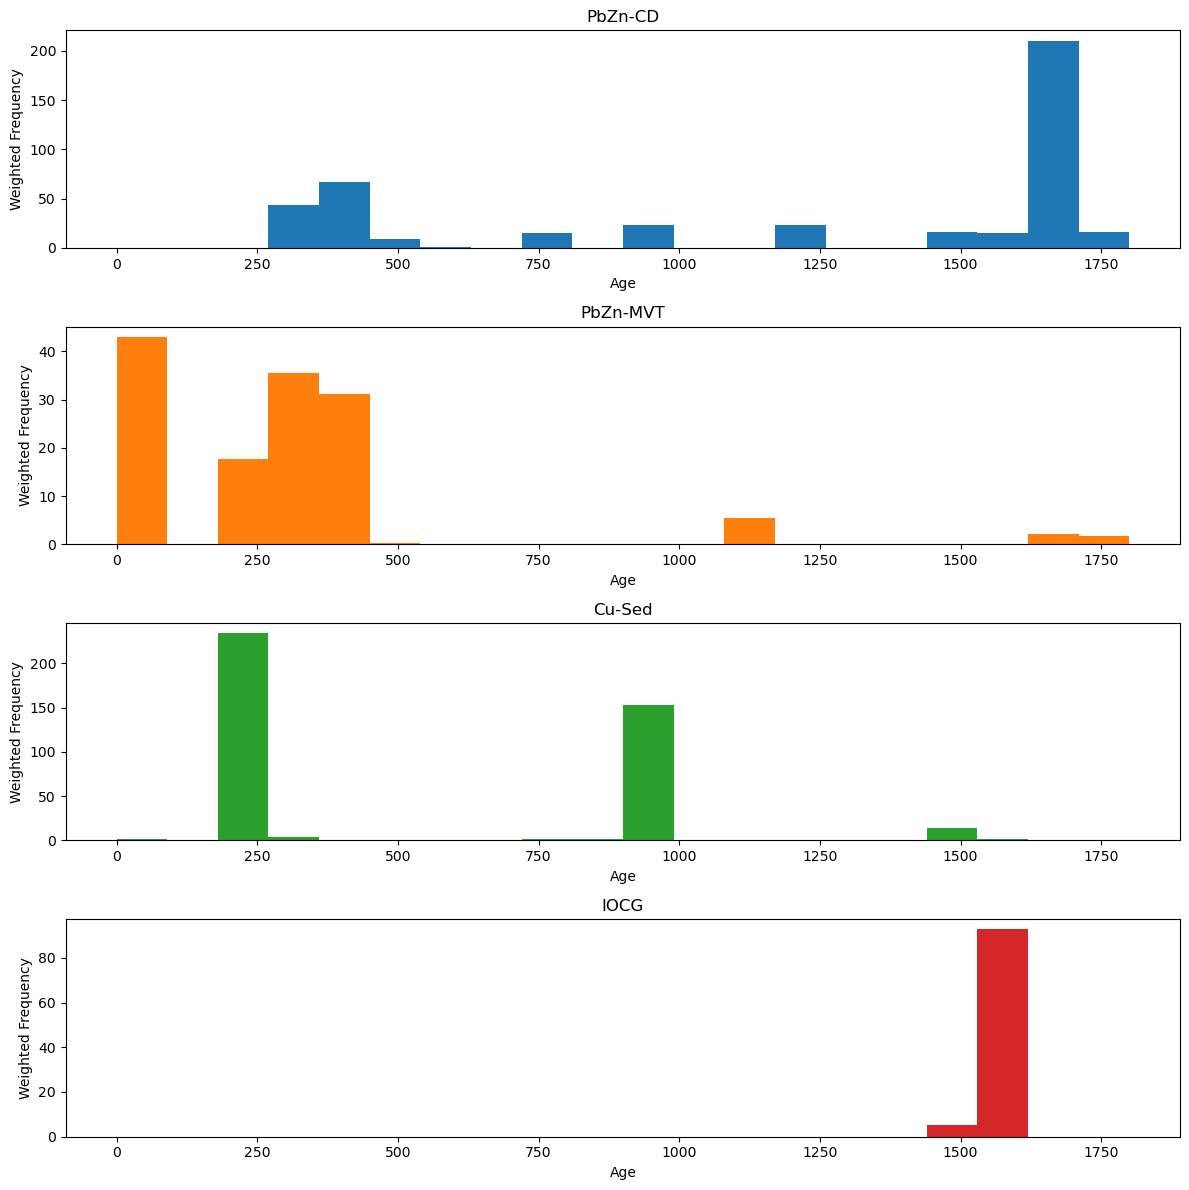

In [70]:
import matplotlib.pyplot as plt

# Create histograms for each mineral type
fig, axes = plt.subplots(len(types), 1, figsize=(12, 12))

# Plot weighted histograms for each type in 'Type' column
for i, type_name in enumerate(types):
    df = metal_dict[type_name]

    # Ensure 'Age' and 'TM2' columns are available and valid
    if 'Age' in df.columns and 'TM2' in df.columns:
        weights = df['TM2'].fillna(0)  # Handle missing values in 'TM2' by filling with 0
        axes[i].hist(df['Age'], range=(0, 1800), bins=20, color=f'C{i}', weights=weights)  # Weighted by 'TM2'
        axes[i].set_title(type_name)
        axes[i].set_xlabel('Age')
        axes[i].set_ylabel('Weighted Frequency')
    else:
        print(f"Missing 'Age' or 'TM2' column for {type_name}")

plt.tight_layout()
plt.show()


<!-- ### Create random continental locations

This is not really being used currently. We have to think more on how to compare our statistical correlations to a random baseline. -->

In [71]:
# import stripy
# mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=4)

# # extract the continent mask from present-day age grid
# gdownload2 = gplately.DataServer("Clennett2020")
# agegrid = gdownload2.get_age_grid(0)
# continent_raster = gplately.Raster(data=agegrid.data.mask.astype(float), extent=extent_global)
# in_continent = continent_raster.interpolate(np.rad2deg(mesh.lons), np.rad2deg(mesh.lats), method='nearest')
# in_continent = in_continent.astype(bool)

In [72]:
# fig = plt.figure(figsize=(10,5))

# ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(), title='Distribution of random points within continents')
# ax1.set_global()
# ax1.coastlines()

# # continental tessellation
# ax1.scatter(np.rad2deg(mesh.lons[in_continent]),
#             np.rad2deg(mesh.lats[in_continent]), 
#             transform=ccrs.Geodetic(), marker='.', color='0.7')

In [73]:
# gpts_random = gplately.Points(model, np.rad2deg(mesh.lons[in_continent]), np.rad2deg(mesh.lats[in_continent]))

# Load craton database

In [74]:
# Load rift datasets with from and to ages
# import os

# rift_filename = "data/segmented_craton_rift/merged_segmented_rift.shp"
# rift_features = pygplates.FeatureCollection(rift_filename)

# for i, feature in enumerate(rift_features):
#     feature.set_shapefile_attribute('TOAGE', 0)
#     FROMAGE, TOAGE = feature.get_valid_time()
#     feature.set_valid_time(FROMAGE, 0)

# rift_filename_new = "{}/{}_toagezero.shp".format(os.path.dirname(rift_filename), os.path.basename(rift_filename))
# rift_features.write(rift_filename_new)


# # read back in and ensure all features have an active time of 0
# fc = pygplates.FeatureCollection(rift_filename_new)
# for feature in fc:
#     if feature.get_shapefile_attribute('TOAGE') != 0:
#         raise ValueError("TOAGE must be zero for all platforms")

In [75]:
reconstruction_time_map = 50

In [76]:
### Load craton database
Craton_HS_filename = "data/segmented_craton_rift/merged_segmented_craton.shp"
Craton_HS_features = pygplates.FeatureCollection(Craton_HS_filename)
reconstructed_Craton_HS_features = model.reconstruct(Craton_HS_features, reconstruction_time_map)
#deposits = '/data/Craton_HS_2B_PLATEID1/Craton_Deposits_PLATEID1.gpml'

## Reconstruct Craton

In [12]:
from scipy.spatial import cKDTree

def KD_dist(lons0, lats0, lons1, lats1, k=1):
    """ Function to efficiently query nearest-neighbour distances """
    x0, y0, z0 = gplately.tools.lonlat2xyz(lons0, lats0)
    x1, y1, z1 = gplately.tools.lonlat2xyz(lons1, lats1)
    
    tree = cKDTree(np.c_[x0, y0, z0])
    d, idx = tree.query(np.c_[x1, y1, z1], k=k)
    return d*gplately.EARTH_RADIUS, idx

In [13]:
# Initialize unique_times as a set to collect unique ages
unique_times = set()

# Loop over each type in types
for i, type_name in enumerate(types):
    df = metal_dict[type_name]
    
    # Collect unique ages from each type and update the set
    unique_times = unique_times.union(set(df['Age'].to_numpy(dtype=int)))

    # # Add new columns to the dataframe with default values
    # # Distance attributes
    # df['distance_to_craton'] = 0.0
    # df['distance_to_random'] = 0.0
    # df['distance_craton_to_trench'] = 0.0

    # # Rift attributes
    # df['craton_age'] = 0.0
    # df['craton_length'] = 0.0
    # df['craton_azimuth'] = 0.0
    # df['craton_velocity'] = 0.0
    # df['craton_velocity_azimuth'] = 0.0

    # # Subduction zone attributes
    # df['trench_convergence_velocity'] = 0.0
    # df['trench_advance'] = 0.0
    # df['trench_azimuth'] = 0.0
    # df['trench_craton_obliquity'] = 0.0

    # Store the updated dataframe back in the metal_dict
    metal_dict[type_name] = df


# Extracting Plate Tectonic Features at Formation Time

In [79]:
# for t, time in enumerate(unique_times):
#     # Reconstruct craton features for the current time
#     reconstructed_craton_features = model.reconstruct(Craton_HS_features, time)

#     # Tessellate subduction zones for the current time
#     subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)
#     subduction_lon = subduction_data[:, 0]
#     subduction_lat = subduction_data[:, 1]
#     subduction_vel = subduction_data[:, 2] * 1e-2
#     subduction_angle = subduction_data[:, 3]
#     subduction_norm = subduction_data[:, 7]
#     subduction_pid_sub = subduction_data[:, 8]
#     subduction_pid_over = subduction_data[:, 9]
#     subduction_length = np.deg2rad(subduction_data[:, 6]) * gplately.EARTH_RADIUS * 1e3  # in meters
#     subduction_convergence = np.fabs(subduction_data[:, 2]) * 1e-2 * np.cos(np.radians(subduction_data[:, 3]))
#     subduction_migration = np.fabs(subduction_data[:, 4]) * 1e-2 * np.cos(np.radians(subduction_data[:, 5]))

#     # Convert lon/lat to xyz coordinates for subduction zones
#     sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
#     tree_sz = cKDTree(np.c_[sx, sy, sz])

#     # Iterate over each mineral type
#     for type_name in types:
#         df = metal_dict[type_name]
#         deposit_age = df['Age'].to_numpy(dtype=int)
#         mask_deposit_ages = deposit_age == time
#         index_deposit_age = df.index[mask_deposit_ages]

#         if not index_deposit_age.any():
#             continue

#         gpts = pts_dict[type_name]
#         rlons, rlats = gpts.reconstruct(time, return_array=True)

#         # Debugging: Print latitudes and longitudes for inspection
#         print(f"Reconstructed latitudes for {type_name}: {rlats}")
#         print(f"Reconstructed longitudes for {type_name}: {rlons}")

#         # Apply strict validation for latitude and longitude values
#         valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)

#         # Filter valid latitudes and longitudes
#         rlons = rlons[valid_mask]
#         rlats = rlats[valid_mask]

#         if len(rlats) == 0 or len(rlons) == 0:
#             print(f"No valid lat/lon points for {type_name} at time {time}")
#             continue

#         # Swap rlons and rlats to ensure they are in the correct order
#         deposit_velocity_components = model.get_point_velocities(rlons, rlats, time)

#         # Calculate the magnitude of the deposit velocities
#         deposit_velocity_magnitude = np.hypot(deposit_velocity_components[:, 0], deposit_velocity_components[:, 1])

#         # Get craton centroids and ages
#         craton_centroids = np.empty((len(reconstructed_craton_features), 2))
#         # craton_from_ages = np.empty(len(reconstructed_craton_features))

#         for f, feature in enumerate(reconstructed_craton_features):
#             geometry = feature.get_reconstructed_geometry()
#             craton_centroids[f, :] = geometry.get_centroid().to_lat_lon()
#             #craton_from_ages[f], _ = feature.get_feature().get_valid_time()

#         # Find closest craton to the deposits
#         distance_to_craton, neighbours = KD_dist(
#             craton_centroids[:, 1], craton_centroids[:, 0], rlons[mask_deposit_ages], rlats[mask_deposit_ages]
#         )

#         for d2r, neighbour, index in zip(distance_to_craton, neighbours, index_deposit_age):
#             feature = reconstructed_craton_features[neighbour]
#             geometry = feature.get_reconstructed_geometry()

#             # Get craton properties
#             craton_length = geometry.get_arc_length() * 6371.0  # Convert arc length to kilometers
#             craton_coordinates = geometry.to_lat_lon_array()
#             #craton_from_age, craton_to_age = feature.get_feature().get_valid_time()

#             # Calculate craton azimuth
#             yx_distances = craton_coordinates[1:] - craton_coordinates[:-1]
#             craton_angles = np.rad2deg(np.arctan2(yx_distances[:, 1], yx_distances[:, 0]))
#             craton_angles[craton_angles < 0] += 180

#             # Calculate craton velocities and azimuth
#             craton_velocity_components = model.get_point_velocities(craton_coordinates[:, 1], craton_coordinates[:, 0], time)
#             craton_velocity_magnitude = np.hypot(craton_velocity_components[:, 0], craton_velocity_components[:, 1])
#             craton_velocity_angle = np.rad2deg(np.arctan2(craton_velocity_components[:, 0], craton_velocity_components[:, 1]))
#             craton_velocity_angle[craton_velocity_angle < 0] += 180

#             # Find nearest subduction zone segment
#             rx, ry, rz = gplately.tools.lonlat2xyz(craton_coordinates[:, 1], craton_coordinates[:, 0])
#             d2s, sz_neighbours = tree_sz.query(np.c_[rx, ry, rz])
#             d2s = d2s.mean() * 6371  # Convert distance to kilometers and ensure it's a single value

#             # Calculate subduction properties for the nearest neighbour
#             sz_convergence = subduction_convergence[sz_neighbours].mean()
#             sz_migration = subduction_migration[sz_neighbours].mean()
#             sz_norm = subduction_norm[sz_neighbours].copy()

#             # Normalize sz_norm to be between 0 and 180
#             sz_norm[sz_norm > 180] -= 180

#             # Calculate the smallest angle difference (obliquity) between the craton and subduction zone
#             sz_obliquity = abs(sz_norm.mean() - craton_angles.mean()) % 180

#             # Limit the obliquity to a maximum of 90 degrees (as obliquity should be between 0 and 90)
#             if sz_obliquity > 90:
#                 sz_obliquity = 180 - sz_obliquity

#             # Update the DataFrame with computed values
#             df.loc[index, 'distance_to_craton'] = d2r
#             df.loc[index, 'craton_length'] = craton_length
#             df.loc[index, 'craton_azimuth'] = craton_angles.mean()
#             df.loc[index, 'craton_velocity'] = craton_velocity_magnitude.mean()
#             df.loc[index, 'craton_velocity_azimuth'] = craton_velocity_angle.mean()
#             #df.loc[index, 'craton_age'] = craton_from_age

#             df.loc[index, 'deposit_velocity'] = deposit_velocity_magnitude.mean()  # Add deposit velocity

#             df.loc[index, 'distance_craton_to_trench'] = d2s
#             df.loc[index, 'trench_convergence_velocity'] = sz_convergence
#             df.loc[index, 'trench_advance'] = sz_migration
#             df.loc[index, 'trench_azimuth'] = sz_norm.mean()
#             df.loc[index, 'trench_craton_obliquity'] = sz_obliquity

#     # Update progress
#     gplately.tools.update_progress((t + 1) / len(unique_times))


In [80]:
for t, time in enumerate(unique_times):
    # Reconstruct craton features for the current time
    reconstructed_craton_features = model.reconstruct(Craton_HS_features, time)

    # Tessellate subduction zones for the current time
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)
    subduction_lon = subduction_data[:, 0]
    subduction_lat = subduction_data[:, 1]
    subduction_vel = subduction_data[:, 2] * 1e-2
    subduction_angle = subduction_data[:, 3]
    subduction_norm = subduction_data[:, 7]
    subduction_pid_sub = subduction_data[:, 8]
    subduction_pid_over = subduction_data[:, 9]
    subduction_length = np.deg2rad(subduction_data[:, 6]) * gplately.EARTH_RADIUS * 1e3  # in meters
    subduction_convergence = np.fabs(subduction_data[:, 2]) * 1e-2 * np.cos(np.radians(subduction_data[:, 3]))
    subduction_migration = np.fabs(subduction_data[:, 4]) * 1e-2 * np.cos(np.radians(subduction_data[:, 5]))

    # Convert lon/lat to xyz coordinates for subduction zones
    sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
    tree_sz = cKDTree(np.c_[sx, sy, sz])  # Create KDTree for nearest neighbor search

    # Iterate over each mineral type
    for type_name in types:
        df = metal_dict[type_name]
        deposit_age = df['Age'].to_numpy(dtype=int)
        mask_deposit_ages = deposit_age == time
        index_deposit_age = df.index[mask_deposit_ages]

        if not index_deposit_age.any():
            continue

        gpts = pts_dict[type_name]
        rlons, rlats = gpts.reconstruct(time, return_array=True)

        # Apply strict validation for latitude and longitude values
        valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)

        # Filter valid latitudes and longitudes
        rlons = rlons[valid_mask]
        rlats = rlats[valid_mask]

        if len(rlats) == 0 or len(rlons) == 0:
            print(f"No valid lat/lon points for {type_name} at time {time}")
            continue

        # Calculate deposit velocities
        deposit_velocity_components = model.get_point_velocities(rlons, rlats, time)
        deposit_velocity_magnitude = np.hypot(deposit_velocity_components[:, 0], deposit_velocity_components[:, 1])

        # Get craton centroids and ages
        craton_centroids = np.empty((len(reconstructed_craton_features), 2))

        for f, feature in enumerate(reconstructed_craton_features):
            geometry = feature.get_reconstructed_geometry()
            craton_centroids[f, :] = geometry.get_centroid().to_lat_lon()

        # Find closest craton to the deposits
        distance_to_craton, neighbours = KD_dist(
            craton_centroids[:, 1], craton_centroids[:, 0], rlons[mask_deposit_ages], rlats[mask_deposit_ages]
        )

        for d2r, neighbour, index in zip(distance_to_craton, neighbours, index_deposit_age):
            feature = reconstructed_craton_features[neighbour]
            geometry = feature.get_reconstructed_geometry()

            # Get craton properties
            craton_length = geometry.get_arc_length() * 6371.0  # Convert arc length to kilometers
            craton_coordinates = geometry.to_lat_lon_array()

            # Calculate craton azimuth
            yx_distances = craton_coordinates[1:] - craton_coordinates[:-1]
            craton_angles = np.rad2deg(np.arctan2(yx_distances[:, 1], yx_distances[:, 0]))
            craton_angles[craton_angles < 0] += 180

            # Calculate craton velocities and azimuth
            craton_velocity_components = model.get_point_velocities(craton_coordinates[:, 1], craton_coordinates[:, 0], time)
            craton_velocity_magnitude = np.hypot(craton_velocity_components[:, 0], craton_velocity_components[:, 1])
            craton_velocity_angle = np.rad2deg(np.arctan2(craton_velocity_components[:, 0], craton_velocity_components[:, 1]))
            craton_velocity_angle[craton_velocity_angle < 0] += 180

            # Find nearest subduction zone segment
            rx, ry, rz = gplately.tools.lonlat2xyz(craton_coordinates[:, 1], craton_coordinates[:, 0])
            d2s, sz_neighbours = tree_sz.query(np.c_[rx, ry, rz])
            d2s = d2s.mean() * 6371  # Convert distance to kilometers and ensure it's a single value

            # Calculate subduction properties for the nearest neighbour
            sz_convergence = subduction_convergence[sz_neighbours].mean()
            sz_migration = subduction_migration[sz_neighbours].mean()
            sz_norm = subduction_norm[sz_neighbours].copy()

            # Normalize sz_norm to be between 0 and 180
            sz_norm[sz_norm > 180] -= 180

            # Calculate the smallest angle difference (obliquity) between the craton and subduction zone
            sz_obliquity = abs(sz_norm.mean() - craton_angles.mean()) % 180

            # Limit the obliquity to a maximum of 90 degrees (as obliquity should be between 0 and 90)
            if sz_obliquity > 90:
                sz_obliquity = 180 - sz_obliquity

            # Update the DataFrame with computed values
            df.loc[index, 'ds_cr_dp'] = d2r
            df.loc[index, 'cr_len'] = craton_length
            df.loc[index, 'cr_az'] = craton_angles.mean()
            df.loc[index, 'cr_ve'] = craton_velocity_magnitude.mean()
            df.loc[index, 'cr_ve_az'] = craton_velocity_angle.mean()

            df.loc[index, 'dp_ve'] = deposit_velocity_magnitude.mean()  # Add deposit velocity

            df.loc[index, 'ds_cr_tr'] = d2s
            df.loc[index, 'sb_ve'] = sz_convergence
            df.loc[index, 'tr_adv'] = sz_migration
            df.loc[index, 'tr_az'] = sz_norm.mean()
            df.loc[index, 'tr_cr_an'] = sz_obliquity

    # Update progress
    gplately.tools.update_progress((t + 1) / len(unique_times))


Progress: [####################] 100.0%


# CDFs

## Cumulative distribution function for distance

In [81]:
def cdf_distance(dist, size):
    idx_sort = dist.argsort()
    dist = dist[idx_sort].copy()
    size = size[idx_sort].copy()
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    return dist, cumsum_size

## Distance craton to trench (km)

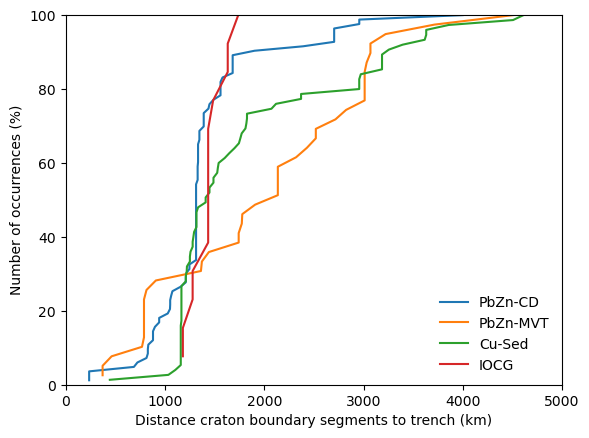

In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0, 5000], ylim=[0, 100], xlabel='Distance craton boundary segments to trench (km)', ylabel='Number of occurrences (%)')

for type_name in types:
    df = metal_dict[type_name]
    
    # Calculate distance and probability for 'distance_craton_to_trench'
    dist, probability = cdf_distance(df['ds_cr_tr'].to_numpy(), np.ones(df.shape[0]))

    # Plot the cumulative distribution function
    ax1.plot(dist, probability * 100, label=type_name)

# Add legend
ax1.legend(loc='lower right', frameon=False)


## Weighted Distance craton to trench (km)

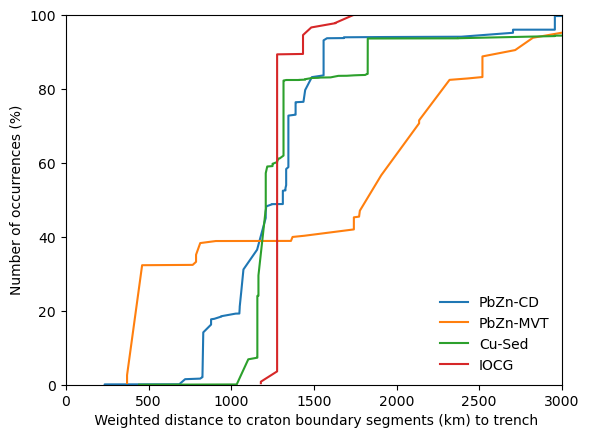

In [83]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0, 3000], ylim=[0, 100], xlabel=' Weighted distance to craton boundary segments (km) to trench', ylabel='Number of occurrences (%)')

for type_name in types:
    df = metal_dict[type_name]

    # Use the 'TM2' column for weights
    weights = df['TM2'].to_numpy()

    # Calculate the weighted CDF using the 'distance_to_craton' column and the weights
    dist, probability = cdf_distance(df['ds_cr_tr'].to_numpy(), weights)

    # Plot the CDF using the weighted probability
    ax1.plot(dist, probability * 100, label=type_name)

ax1.legend(loc='lower right', frameon=False)


## Distance Deposits to craton vertices (km)

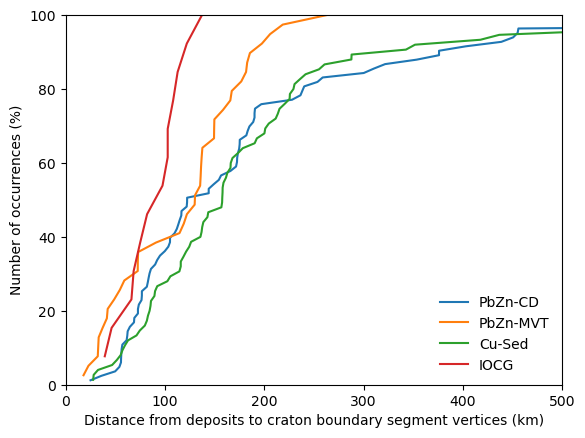

In [84]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0, 500], ylim=[0, 100], xlabel='Distance from deposits to craton boundary segment vertices (km)', ylabel='Number of occurrences (%)')

for type_name in types:
    df = metal_dict[type_name]
    dist, probability = cdf_distance(df['ds_cr_dp'].to_numpy(), np.ones(df.shape[0]))

    ax1.plot(dist, probability * 100, label=type_name)

ax1.legend(loc='lower right', frameon=False)


## Weighted Distance Deposits to craton (km)

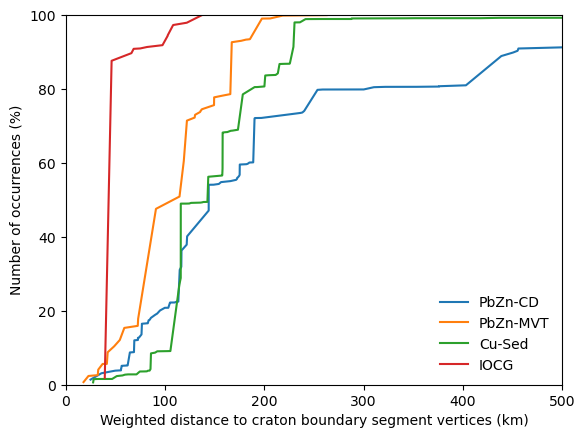

In [85]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0, 500], ylim=[0, 100], xlabel='Weighted distance to craton boundary segment vertices (km)', ylabel='Number of occurrences (%)')

for type_name in types:
    df = metal_dict[type_name]
    
    # Use the 'TM2' column as weights
    dist, probability = cdf_distance(df['ds_cr_dp'].to_numpy(), df['TM2'].to_numpy())

    # Plot CDF, converting probabilities to percentages
    ax1.plot(dist, probability * 100, label=type_name)

# Add legend
ax1.legend(loc='lower right', frameon=False)

plt.show()


## Distance calculated with  another function (stored in column 'craton_dis')

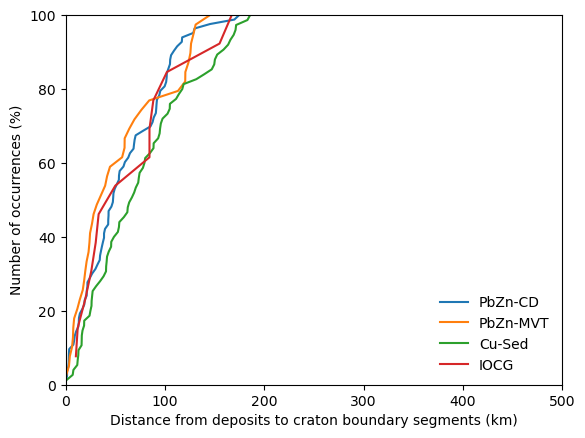

In [86]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0, 500], ylim=[0, 100], xlabel='Distance from deposits to craton boundary segments (km)', ylabel='Number of occurrences (%)')

for type_name in types:
    df = metal_dict[type_name]

    # Use the 'craton_dis' column instead of calling the distance function
    dist = df['craton_dis'].to_numpy()  # Assuming 'craton_dis' is already in kilometers
    
    # Ensure that 'cdf_distance' returns 1D arrays
    dist, probability = cdf_distance(dist, np.ones(df.shape[0]))
    
    # Ensure probability is 1D and matches the length of dist
    if probability.ndim > 1:
        probability = probability.squeeze()  # Flatten if it's a 2D array
    
    # Plot the CDF using the distance and probability
    ax1.plot(dist, probability * 100, label=type_name)

ax1.legend(loc='lower right', frameon=False)


## Weighted CDF based on column "TM2"

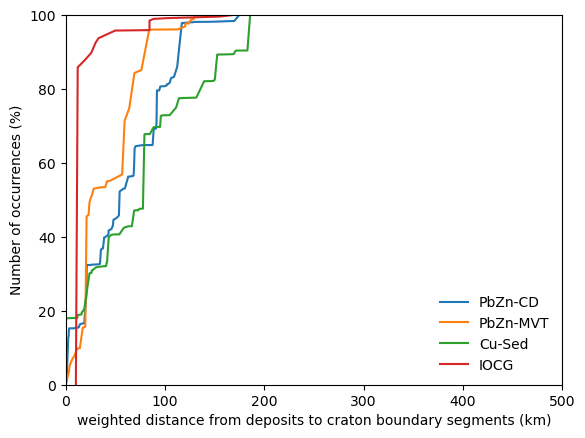

In [87]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0, 500], ylim=[0, 100], xlabel='weighted distance from deposits to craton boundary segments (km)', ylabel='Number of occurrences (%)')

for type_name in types:
    df = metal_dict[type_name]

    # Use the 'craton_dis' column instead of calling the distance function
    dist = df['craton_dis'].to_numpy()  # Assuming 'craton_dis' is already in kilometers
    
    # Use the 'TM2' column as weights for the weighted CDF
    weights = df['TM2'].to_numpy()

    # Calculate weighted CDF
    dist, probability = cdf_distance(dist, weights)
    
    # Ensure probability is 1D and matches the length of dist
    if probability.ndim > 1:
        probability = probability.squeeze()  # Flatten if it's a 2D array
    
    # Plot the weighted CDF using the distance and probability
    ax1.plot(dist, probability * 100, label=type_name)

# Add legend
ax1.legend(loc='lower right', frameon=False)


# Formation Time

## Histograms (No.)

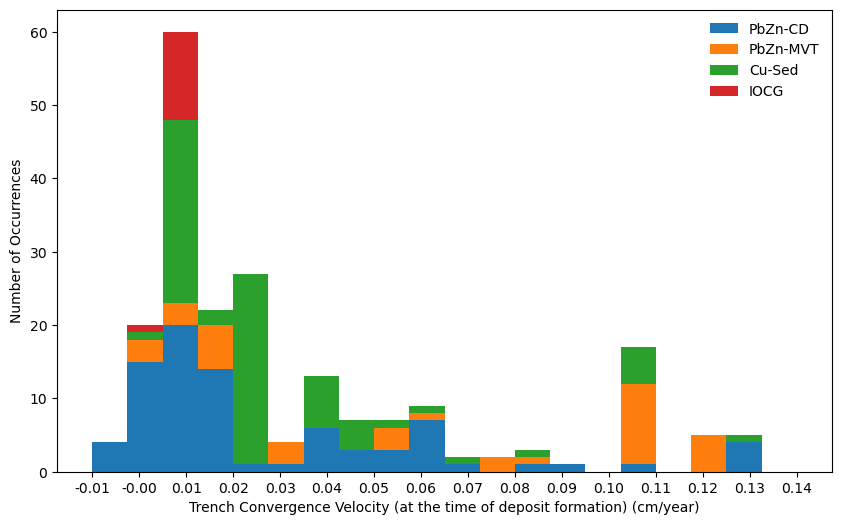

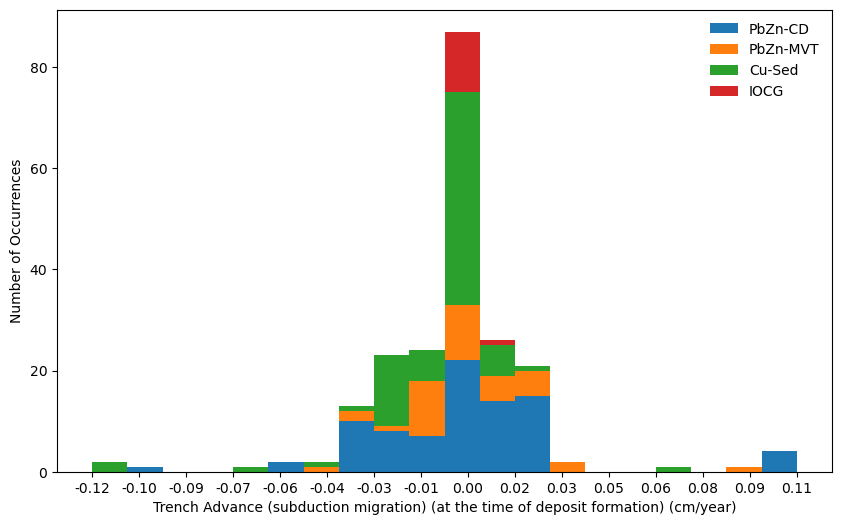

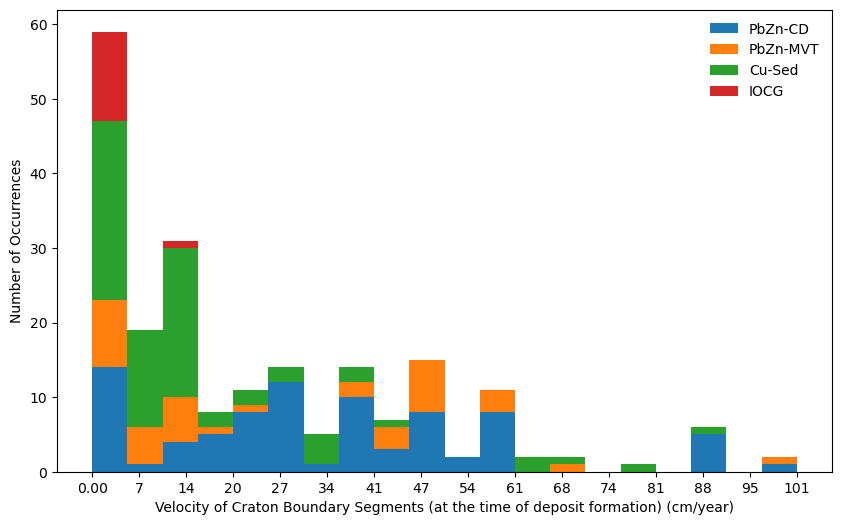

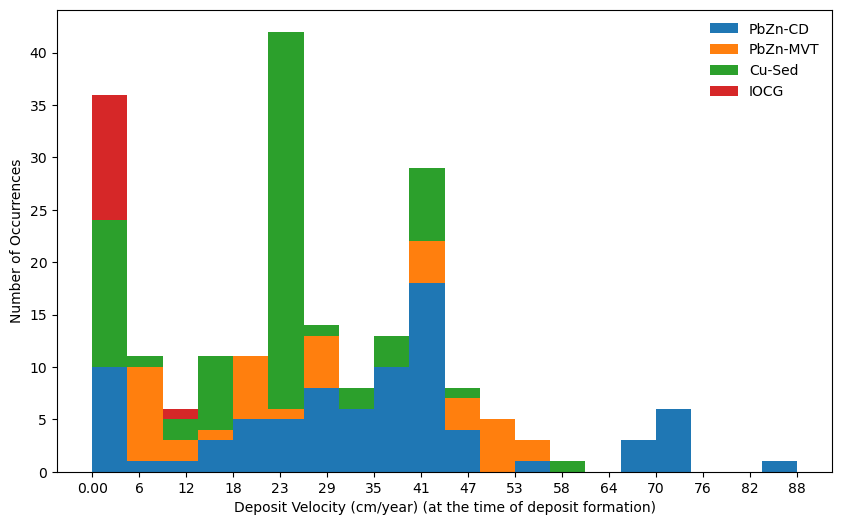

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    #"craton_length": "Length of Craton Boundary Segments (km)",
    "sb_ve": "Trench Convergence Velocity (at the time of deposit formation) (cm/year)",
    "tr_adv": "Trench Advance (subduction migration) (at the time of deposit formation) (cm/year)",
    "cr_ve": "Velocity of Craton Boundary Segments (at the time of deposit formation) (cm/year)",
    "dp_ve": "Deposit Velocity (cm/year) (at the time of deposit formation)"
}

# Loop over the variables for plotting
for label in [
    #"craton_length",
    #"craton_age",
    "sb_ve",
    "tr_adv",
    "cr_ve",
    "dp_ve",
]:
    # Set the figure size (you can adjust this size)
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Number of Occurrences')

    variable_stack = []
    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan
        df = df.replace(np.inf, np.nan)
        variable_stack.append(df[label])

        # Calculate percentiles for vmin and vmax, handling NaNs properly
        current_vmin = np.nanpercentile(df[label], 1)
        current_vmax = np.nanpercentile(df[label], 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Ensure that vmin is 0 or lower (for including negative values)
    vmin = min(vmin, 0)

    # Plotting the stacked histogram with custom bins
    ax1.hist(variable_stack, bins=20, range=(vmin, vmax), stacked=True, label=types)
    ax1.legend(loc="upper right", frameon=False)

    # Set the step size to create evenly spaced ticks and ensure the ticks start from 0
    step_size = (vmax - vmin) / 15  # Divides the range into 10 equal intervals
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.2f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

    # Show the plot for each iteration
    plt.show()


## Weighted Histograms

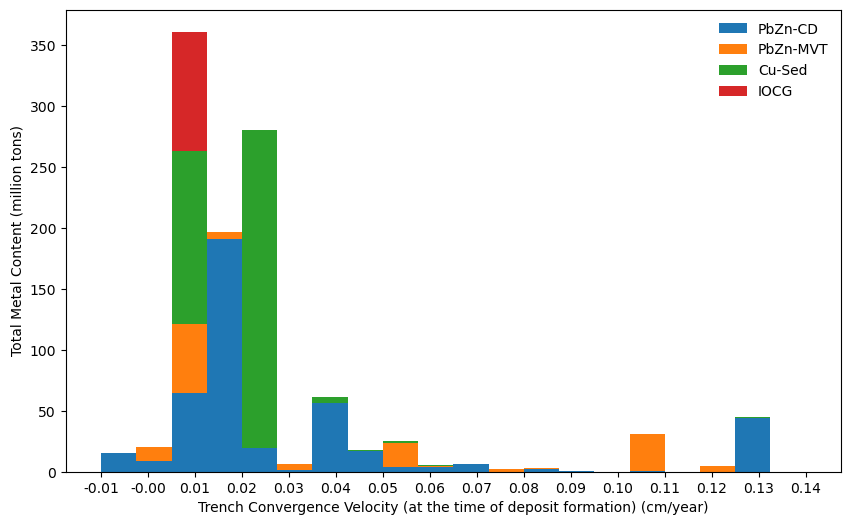

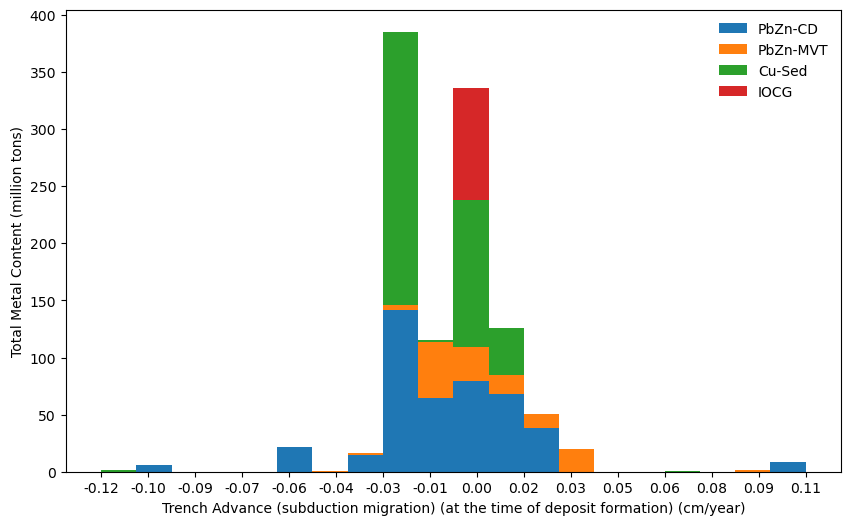

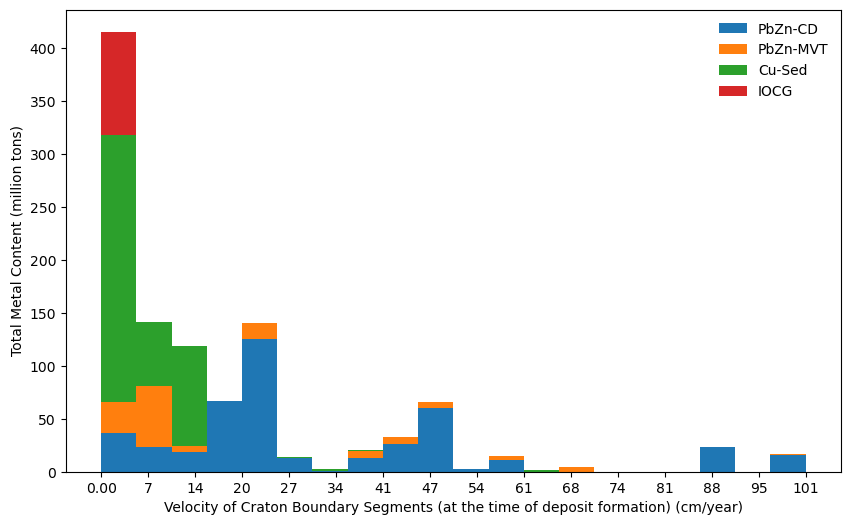

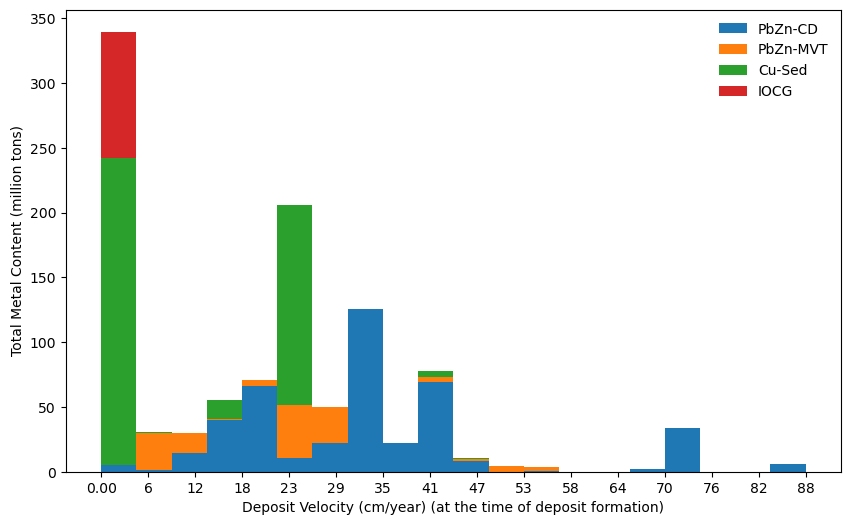

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    #"craton_length": "Length of Craton Boundary Segments (km)",
    "sb_ve": "Trench Convergence Velocity (at the time of deposit formation) (cm/year)",
    "tr_adv": "Trench Advance (subduction migration) (at the time of deposit formation) (cm/year)",
    "cr_ve": "Velocity of Craton Boundary Segments (at the time of deposit formation) (cm/year)",
    "dp_ve": "Deposit Velocity (cm/year) (at the time of deposit formation)"
}

# Loop over the variables for plotting
for label in [
    #"craton_length",
    #"craton_age",
    "sb_ve",
    "tr_adv",
    "cr_ve",
    "dp_ve",
]:
    # Set the figure size (you can adjust this size)
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Total Metal Content (million tons)')
    variable_stack = []
    weight_stack = []
    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan
        df = df.replace(np.inf, np.nan)

        # Get the variable and weights
        variable = df[label].to_numpy()
        weights = df['TM2'].to_numpy()  # Use TM2 column as weights

        variable_stack.append(variable)
        weight_stack.append(weights)

        # Calculate percentiles for vmin and vmax, handling NaNs properly
        current_vmin = np.nanpercentile(variable, 1)
        current_vmax = np.nanpercentile(variable, 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Ensure that vmin is 0 or lower (for including negative values)
    vmin = min(vmin, 0)

    # Plotting the stacked weighted histogram with custom bins
    ax1.hist(variable_stack, bins=20, range=(vmin, vmax), weights=weight_stack, stacked=True, label=types)
    ax1.legend(loc="upper right", frameon=False)

    # Set the step size to create evenly spaced ticks and ensure the ticks start from 0
    step_size = (vmax - vmin) / 15  # Divides the range into 15 equal intervals
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.2f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

# Show the plot for each iteration
plt.show()


## Rose diagrams (No.)

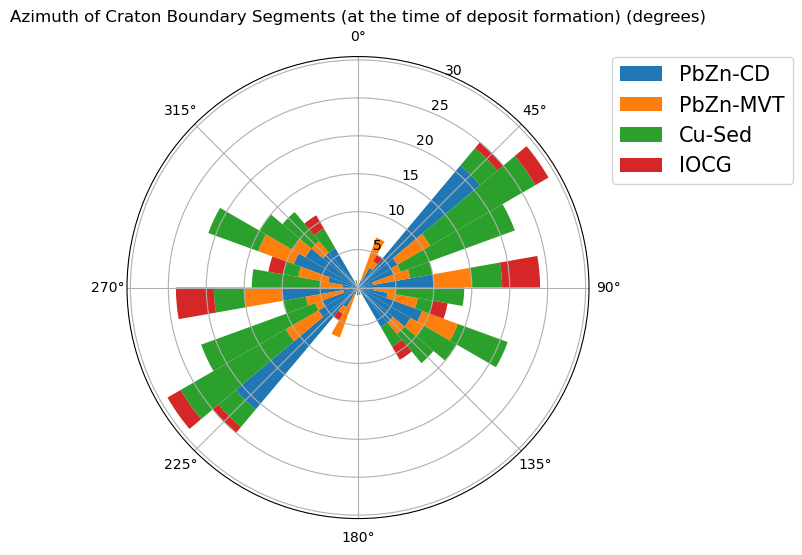

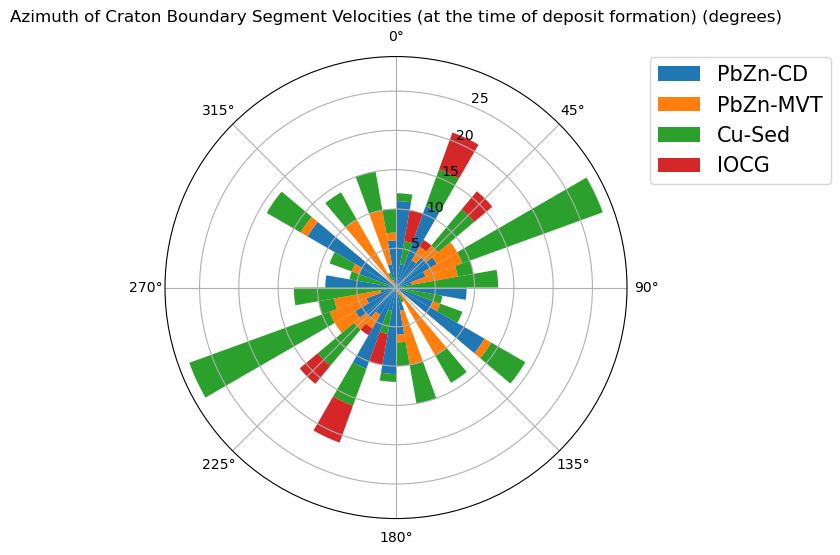

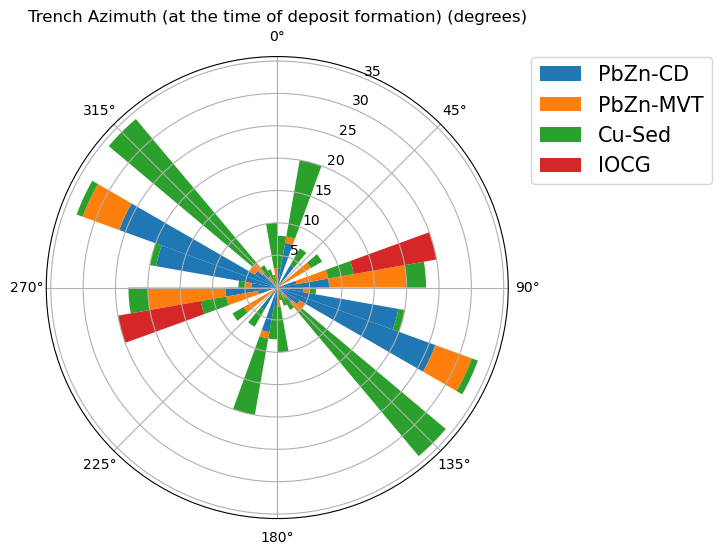

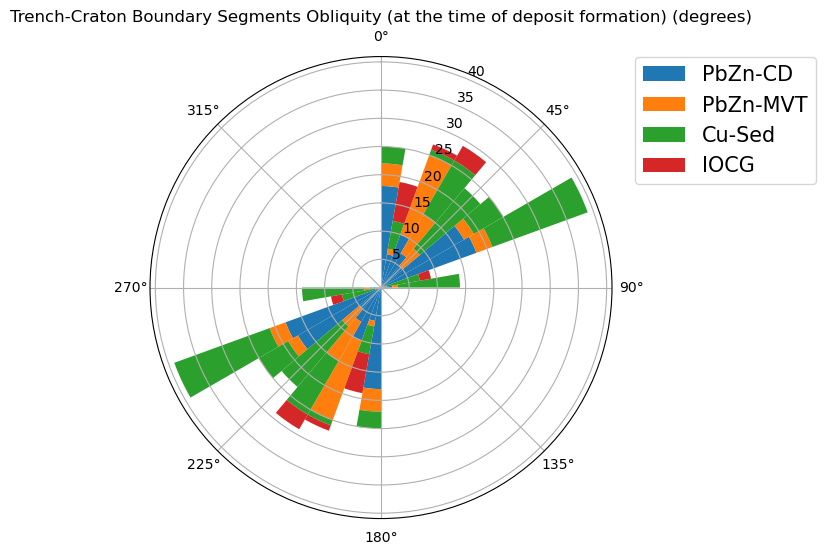

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "cr_az": "Azimuth of Craton Boundary Segments (at the time of deposit formation) (degrees)",
    "cr_ve_az": "Azimuth of Craton Boundary Segment Velocities (at the time of deposit formation) (degrees)",
    "tr_az": "Trench Azimuth (at the time of deposit formation) (degrees)",
    "tr_cr_an": "Trench-Craton Boundary Segments Obliquity (at the time of deposit formation) (degrees)"
}

# Loop over the variables for plotting
for label in [
    "cr_az",
    "cr_ve_az",
    "tr_az",
    "tr_cr_an",
]:
    # Set the figure size (you can adjust this size)
    fig = plt.figure(figsize=(6, 6))  # Adjusting figure size for polar plot
    ax1 = fig.add_subplot(111, polar=True)

    # Set the direction and offset for the polar plot
    ax1.set_theta_direction(-1)
    ax1.set_theta_offset(np.pi / 2.0)

    # Set the title using custom labels
    ax1.set_title(custom_labels[label])

    variable_stack = []
    for type_name in types:
        df = metal_dict[type_name]
        azimuths = np.hstack([df[label], df[label] + 180])  # Ensuring 0-360 coverage for azimuth
        variable_stack.append(np.deg2rad(azimuths))  # Convert to radians

    # Plot the stacked histogram in the polar plot
    ax1.hist(variable_stack, stacked=True, range=(0, np.pi * 2), bins=36, label=types)

    # Place the legend outside the circle with a specified font size
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})  # Adjust legend size

# Show the plot for each iteration
plt.show()


## Weighted Rose diagrams

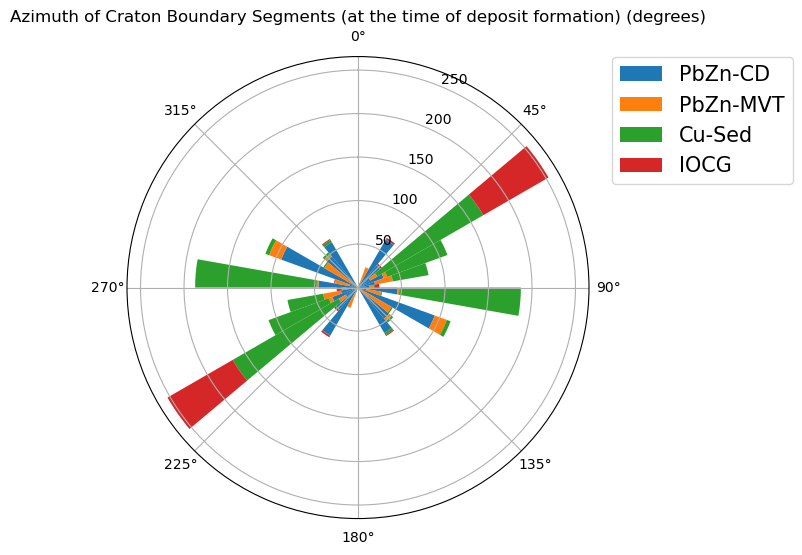

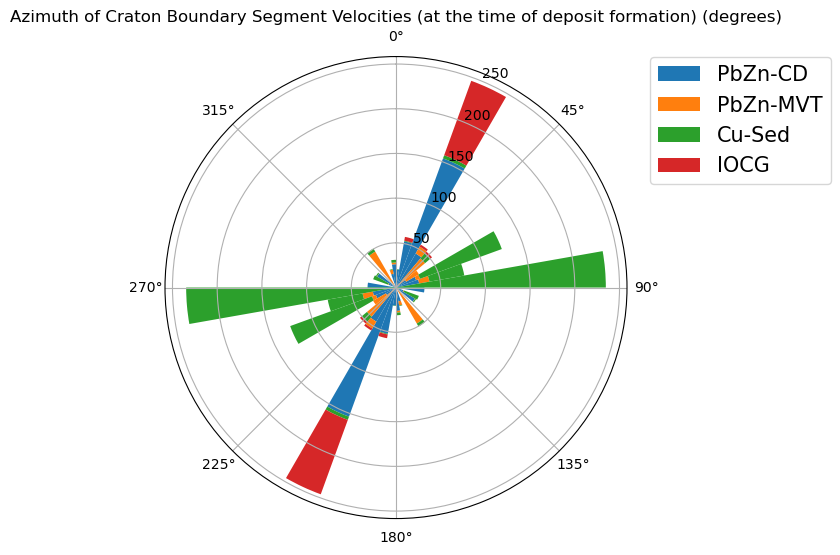

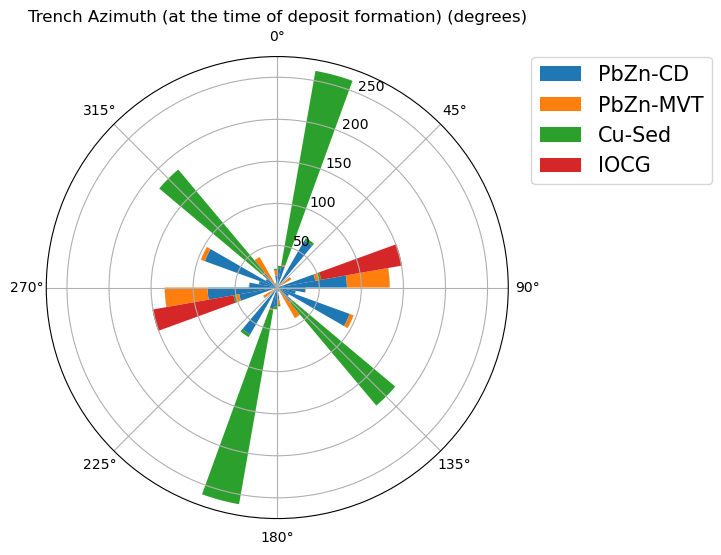

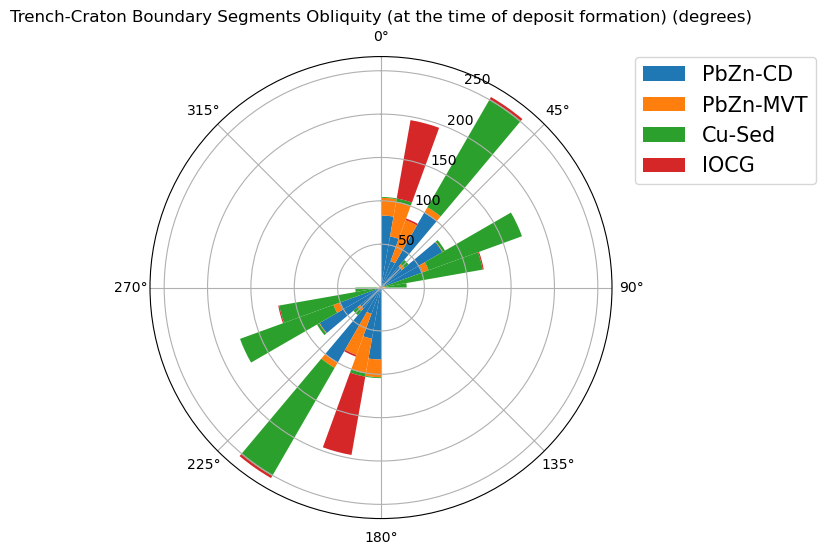

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "cr_az": "Azimuth of Craton Boundary Segments (at the time of deposit formation) (degrees)",
    "cr_ve_az": "Azimuth of Craton Boundary Segment Velocities (at the time of deposit formation) (degrees)",
    "tr_az": "Trench Azimuth (at the time of deposit formation) (degrees)",
    "tr_cr_an": "Trench-Craton Boundary Segments Obliquity (at the time of deposit formation) (degrees)"
}

# Loop over the variables for plotting
for label in [
    "cr_az",
    "cr_ve_az",
    "tr_az",
    "tr_cr_an",
]:
    # Set the figure size for polar plot
    fig = plt.figure(figsize=(6, 6))  # Adjusting figure size for polar plot
    ax1 = fig.add_subplot(111, polar=True)

    # Set the direction and offset for the polar plot
    ax1.set_theta_direction(-1)
    ax1.set_theta_offset(np.pi / 2.0)

    # Set the title using custom labels
    ax1.set_title(custom_labels[label])

    variable_stack = []
    weight_stack = []

    for type_name in types:
        df = metal_dict[type_name]

        # Extract the azimuths and add 180 to ensure full 0-360 coverage
        azimuths = np.hstack([df[label], df[label] + 180])
        variable_stack.append(np.deg2rad(azimuths))  # Convert azimuths to radians
        
        # Use 'TM2' as weights and apply the same weights for mirrored azimuths
        weights = np.hstack([df['TM2'], df['TM2']])
        weight_stack.append(weights)

    # Plot the weighted polar histogram
    ax1.hist(variable_stack, stacked=True, weights=weight_stack, range=(0, np.pi * 2), bins=36, label=types)

    # Place the legend outside the circle with a specified font size
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})  # Adjust legend size

# Show the plot for each iteration
plt.show()


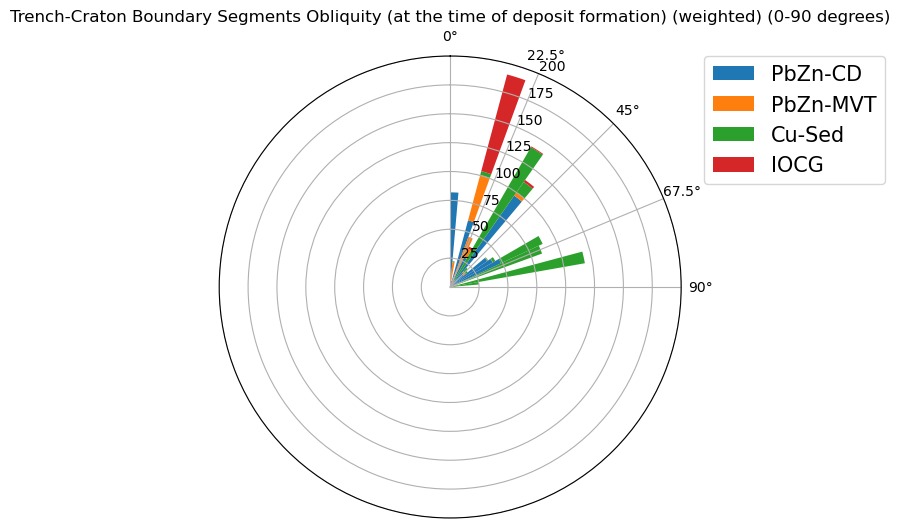

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure and polar subplot
fig = plt.figure(figsize=(6, 6))  # Adjusting figure size for polar plot
ax1 = fig.add_subplot(111, polar=True)

# Set the direction and offset for the polar plot
ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.pi / 2.0)

# Set the title for the polar plot
ax1.set_title('Trench-Craton Boundary Segments Obliquity (at the time of deposit formation) (weighted) (0-90 degrees)')

variable_stack = []
weight_stack = []

for type_name in types:
    df = metal_dict[type_name]

    # Extract the trench-craton obliquity and clip it between 0 and 90 degrees
    obliquity = df['tr_cr_an'].to_numpy()
    obliquity = np.clip(obliquity, 0, 90)  # Ensure values are within 0-90 range
    
    variable_stack.append(np.deg2rad(obliquity))  # Convert to radians
    
    # Use 'TM2' as weights
    weights = df['TM2'].to_numpy()
    weight_stack.append(weights)

# Plot the weighted polar histogram for obliquity
ax1.hist(variable_stack, stacked=True, weights=weight_stack, range=(0, np.pi / 2), bins=18, label=types)

# Set x-ticks for 0, 22.5, 45, 67.5, 90 degrees
ax1.set_xticks(np.linspace(0, np.pi / 2, 5))
ax1.set_xticklabels(['0°', '22.5°', '45°', '67.5°', '90°'])

# Move the legend to the outside lower left
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})

# Show the plot
plt.show()


# Over a a-million-year period (Median)

## Extracting Plate Tectonic Features (3-Million-year)

In [93]:
# calculate the nearest craton segments for each deposit, along with the nearest subduction zone segments

In [94]:
# median

In [95]:
import numpy as np

a = 20
for t, time in enumerate(unique_times):
    # Reconstruct craton features for the current time
    reconstructed_craton_features = model.reconstruct(Craton_HS_features, time)

    # Tessellate subduction zones for the current time
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)
    subduction_lon = subduction_data[:, 0]
    subduction_lat = subduction_data[:, 1]
    subduction_vel = subduction_data[:, 2] * 1e-2
    subduction_angle = subduction_data[:, 3]
    subduction_norm = subduction_data[:, 7]
    subduction_pid_sub = subduction_data[:, 8]
    subduction_pid_over = subduction_data[:, 9]
    subduction_length = np.deg2rad(subduction_data[:, 6]) * gplately.EARTH_RADIUS * 1e3  # in meters
    subduction_convergence = np.fabs(subduction_data[:, 2]) * 1e-2 * np.cos(np.radians(subduction_data[:, 3]))
    subduction_migration = np.fabs(subduction_data[:, 4]) * 1e-2 * np.cos(np.radians(subduction_data[:, 5]))

    # Convert lon/lat to xyz coordinates for subduction zones
    sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
    tree_sz = cKDTree(np.c_[sx, sy, sz])  # Create KDTree for nearest neighbor search

    # Calculate craton centroids and velocities
    craton_centroids = np.empty((len(reconstructed_craton_features), 2))
    for f, feature in enumerate(reconstructed_craton_features):
        geometry = feature.get_reconstructed_geometry()
        craton_centroids[f, :] = geometry.get_centroid().to_lat_lon()

    # Convert craton centroids to xyz coordinates for KDTree search
    cx, cy, cz = gplately.tools.lonlat2xyz(craton_centroids[:, 1], craton_centroids[:, 0])
    tree_craton = cKDTree(np.c_[cx, cy, cz])  # Create KDTree for nearest craton search

    # Iterate over each mineral type
    for type_name in types:
        df = metal_dict[type_name]
        deposit_age = df['Age'].to_numpy(dtype=int)
        mask_deposit_ages = deposit_age == time
        index_deposit_age = df.index[mask_deposit_ages]

        if not index_deposit_age.any():
            continue

        gpts = pts_dict[type_name]
        rlons, rlats = gpts.reconstruct(time, return_array=True)

        # Apply strict validation for latitude and longitude values
        valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)

        # Filter valid latitudes and longitudes
        rlons = rlons[valid_mask]
        rlats = rlats[valid_mask]

        if len(rlats) == 0 or len(rlons) == 0:
            print(f"No valid lat/lon points for {type_name} at time {time}")
            continue

        # Initialize lists for 3-year data
        deposit_velocity_values = []
        craton_velocity_values = []
        craton_velocity_azimuth_values = []
        trench_craton_obliquity_values = []
        trench_convergence_values = []
        trench_advance_values = []

        # Loop for the a years prior to the deposit's formation age
        for year_offset in range(a):
            avg_time = time - year_offset
            gpts = pts_dict[type_name]
            rlons, rlats = gpts.reconstruct(avg_time, return_array=True)

            valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)
            rlons = rlons[valid_mask]
            rlats = rlats[valid_mask]

            if len(rlons) == 0 or len(rlats) == 0:
                continue

            # Calculate deposit velocities
            deposit_velocity_components = model.get_point_velocities(rlons, rlats, avg_time)
            deposit_velocity_magnitude = np.hypot(deposit_velocity_components[:, 0], deposit_velocity_components[:, 1])
            deposit_velocity_values.append(deposit_velocity_magnitude)

            # Convert deposit lon/lat to xyz
            deposit_xyz = np.c_[gplately.tools.lonlat2xyz(rlons, rlats)]

            # Find the nearest subduction zone segment for each deposit
            d2sz, sz_neighbours = tree_sz.query(deposit_xyz)  # Get closest subduction zone

            # Calculate subduction properties for the nearest subduction zone
            closest_convergence = subduction_convergence[sz_neighbours].mean()
            closest_migration = subduction_migration[sz_neighbours].mean()

            # Find the nearest craton segment for each deposit
            d2craton, craton_neighbours = tree_craton.query(deposit_xyz)  # Get closest craton

            # Calculate craton velocities and azimuth
            craton_velocity_components = model.get_point_velocities(craton_centroids[craton_neighbours, 1], craton_centroids[craton_neighbours, 0], avg_time)
            craton_velocity_magnitude = np.hypot(craton_velocity_components[:, 0], craton_velocity_components[:, 1])
            craton_velocity_angle = np.rad2deg(np.arctan2(craton_velocity_components[:, 0], craton_velocity_components[:, 1]))
            craton_velocity_angle[craton_velocity_angle < 0] += 180

            # Calculate obliquity between the craton and the subduction zone
            sz_obliquity = abs(subduction_norm[sz_neighbours].mean() - craton_velocity_angle.mean()) % 180
            if sz_obliquity > 90:
                sz_obliquity = 180 - sz_obliquity

            # Append values for median calculation
            craton_velocity_values.append(craton_velocity_magnitude)
            craton_velocity_azimuth_values.append(craton_velocity_angle)
            trench_craton_obliquity_values.append(sz_obliquity)
            trench_convergence_values.append(closest_convergence)
            trench_advance_values.append(closest_migration)

        # If any data was collected, calculate medians
        if deposit_velocity_values:
            deposit_velocity_med_a = np.median(np.concatenate(deposit_velocity_values))
            craton_velocity_med_a = np.median(np.concatenate(craton_velocity_values))
            craton_velocity_azimuth_med_a = np.median(np.concatenate(craton_velocity_azimuth_values))
            trench_craton_obliquity_med_a = np.median(trench_craton_obliquity_values)
            trench_convergence_med_a = np.median(trench_convergence_values)
            trench_advance_med_a = np.median(trench_advance_values)

            # Update DataFrame with 3-year medians
            df.loc[index_deposit_age, 'dp_ve_m'] = deposit_velocity_med_a
            df.loc[index_deposit_age, 'cr_ve_m'] = craton_velocity_med_a
            df.loc[index_deposit_age, 'cr_ve_az_m'] = craton_velocity_azimuth_med_a
            df.loc[index_deposit_age, 'tr_cr_an_m'] = trench_craton_obliquity_med_a
            df.loc[index_deposit_age, 'sb_ve_m'] = trench_convergence_med_a
            df.loc[index_deposit_age, 'tr_adv_m'] = trench_advance_med_a

    # Update progress
    gplately.tools.update_progress((t + 1) / len(unique_times))


Progress: [####################] 100.0%


In [96]:
# for t, time in enumerate(unique_times):
#     # Reconstruct craton features for the current time
#     reconstructed_craton_features = model.reconstruct(Craton_HS_features, time)

#     # Tessellate subduction zones for the current time
#     subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)
#     subduction_lon = subduction_data[:, 0]
#     subduction_lat = subduction_data[:, 1]
#     subduction_vel = subduction_data[:, 2] * 1e-2
#     subduction_angle = subduction_data[:, 3]
#     subduction_norm = subduction_data[:, 7]
#     subduction_pid_sub = subduction_data[:, 8]
#     subduction_pid_over = subduction_data[:, 9]
#     subduction_length = np.deg2rad(subduction_data[:, 6]) * gplately.EARTH_RADIUS * 1e3  # in meters
#     subduction_convergence = np.fabs(subduction_data[:, 2]) * 1e-2 * np.cos(np.radians(subduction_data[:, 3]))
#     subduction_migration = np.fabs(subduction_data[:, 4]) * 1e-2 * np.cos(np.radians(subduction_data[:, 5]))

#     # Convert lon/lat to xyz coordinates for subduction zones
#     sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
#     tree_sz = cKDTree(np.c_[sx, sy, sz])  # Create KDTree for nearest neighbor search

#     # Iterate over each mineral type
#     for type_name in types:
#         df = metal_dict[type_name]
#         deposit_age = df['Age'].to_numpy(dtype=int)
#         mask_deposit_ages = deposit_age == time
#         index_deposit_age = df.index[mask_deposit_ages]

#         if not index_deposit_age.any():
#             continue

#         gpts = pts_dict[type_name]
#         rlons, rlats = gpts.reconstruct(time, return_array=True)

#         # Apply strict validation for latitude and longitude values
#         valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)

#         # Filter valid latitudes and longitudes
#         rlons = rlons[valid_mask]
#         rlats = rlats[valid_mask]

#         if len(rlats) == 0 or len(rlons) == 0:
#             print(f"No valid lat/lon points for {type_name} at time {time}")
#             continue

#         # Initialize accumulators for 3-year averages
#         deposit_velocity_sum = 0
#         craton_velocity_sum = 0
#         craton_velocity_azimuth_sum = 0
#         trench_craton_obliquity_sum = 0
#         trench_convergence_sum = 0
#         trench_advance_sum = 0
#         count = 0

#         # Loop for the 3 years prior to the deposit's formation age
#         for year_offset in range(3):
#             avg_time = time - year_offset
#             gpts = pts_dict[type_name]
#             rlons, rlats = gpts.reconstruct(avg_time, return_array=True)

#             valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)
#             rlons = rlons[valid_mask]
#             rlats = rlats[valid_mask]

#             if len(rlons) == 0 or len(rlats) == 0:
#                 continue

#             # Calculate deposit velocities
#             deposit_velocity_components = model.get_point_velocities(rlons, rlats, avg_time)
#             deposit_velocity_magnitude = np.hypot(deposit_velocity_components[:, 0], deposit_velocity_components[:, 1])
#             deposit_velocity_sum += deposit_velocity_magnitude.mean()

#             # Convert deposit lon/lat to xyz
#             deposit_xyz = np.c_[gplately.tools.lonlat2xyz(rlons, rlats)]

#             # Find the nearest subduction zone segment for each deposit
#             d2sz, sz_neighbours = tree_sz.query(deposit_xyz)  # Get closest subduction zone

#             # Calculate subduction properties for the nearest subduction zone
#             closest_convergence = subduction_convergence[sz_neighbours].mean()
#             closest_migration = subduction_migration[sz_neighbours].mean()

#             # Get craton centroids and ages
#             craton_centroids = np.empty((len(reconstructed_craton_features), 2))

#             for f, feature in enumerate(reconstructed_craton_features):
#                 geometry = feature.get_reconstructed_geometry()
#                 craton_centroids[f, :] = geometry.get_centroid().to_lat_lon()

#             # Calculate craton velocities and azimuth
#             craton_velocity_components = model.get_point_velocities(craton_centroids[:, 1], craton_centroids[:, 0], avg_time)
#             craton_velocity_magnitude = np.hypot(craton_velocity_components[:, 0], craton_velocity_components[:, 1])
#             craton_velocity_angle = np.rad2deg(np.arctan2(craton_velocity_components[:, 0], craton_velocity_components[:, 1]))
#             craton_velocity_angle[craton_velocity_angle < 0] += 180

#             # Calculate obliquity between the craton and the subduction zone
#             sz_obliquity = abs(subduction_norm[sz_neighbours].mean() - craton_velocity_angle.mean()) % 180
#             if sz_obliquity > 90:
#                 sz_obliquity = 180 - sz_obliquity

#             # Add to sums
#             craton_velocity_sum += craton_velocity_magnitude.mean()
#             craton_velocity_azimuth_sum += craton_velocity_angle.mean()
#             trench_craton_obliquity_sum += sz_obliquity
#             trench_convergence_sum += closest_convergence
#             trench_advance_sum += closest_migration

#             count += 1

#         if count > 0:
#             # Calculate averages
#             deposit_velocity_avg = deposit_velocity_sum / count
#             craton_velocity_avg = craton_velocity_sum / count
#             craton_velocity_azimuth_avg = craton_velocity_azimuth_sum / count
#             trench_craton_obliquity_avg = trench_craton_obliquity_sum / count
#             trench_convergence_avg = trench_convergence_sum / count
#             trench_advance_avg = trench_advance_sum / count

#             # Update DataFrame with 3-year averages
#             df.loc[index_deposit_age, 'deposit_velocity_avg'] = deposit_velocity_avg
#             df.loc[index_deposit_age, 'craton_velocity_avg'] = craton_velocity_avg
#             df.loc[index_deposit_age, 'craton_velocity_azimuth_avg'] = craton_velocity_azimuth_avg
#             df.loc[index_deposit_age, 'trench_craton_obliquity_avg'] = trench_craton_obliquity_avg
#             df.loc[index_deposit_age, 'trench_convergence_velocity_avg'] = trench_convergence_avg
#             df.loc[index_deposit_age, 'trench_advance_avg'] = trench_advance_avg

#     # Update progress
#     gplately.tools.update_progress((t + 1) / len(unique_times))


In [97]:
# check

In [98]:
# # Initialize accumulators for year-wise sums across all deposits
# yearwise_deposit_velocity_sum = {0: 0, 1: 0, 2: 0}
# yearwise_craton_velocity_sum = {0: 0, 1: 0, 2: 0}
# yearwise_craton_velocity_azimuth_sum = {0: 0, 1: 0, 2: 0}
# yearwise_trench_craton_obliquity_sum = {0: 0, 1: 0, 2: 0}
# yearwise_trench_convergence_sum = {0: 0, 1: 0, 2: 0}
# yearwise_trench_advance_sum = {0: 0, 1: 0, 2: 0}

# # Initialize a count to keep track of the number of valid deposits each year
# yearwise_count = {0: 0, 1: 0, 2: 0}

# for t, time in enumerate(unique_times):
#     # Reconstruct craton features for the current time
#     reconstructed_craton_features = model.reconstruct(Craton_HS_features, time)

#     # Tessellate subduction zones for the current time
#     subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)
#     subduction_lon = subduction_data[:, 0]
#     subduction_lat = subduction_data[:, 1]
#     subduction_convergence = np.fabs(subduction_data[:, 2]) * 1e-2 * np.cos(np.radians(subduction_data[:, 3]))
#     subduction_migration = np.fabs(subduction_data[:, 4]) * 1e-2 * np.cos(np.radians(subduction_data[:, 5]))

#     # Convert lon/lat to xyz coordinates for subduction zones
#     sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
#     tree_sz = cKDTree(np.c_[sx, sy, sz])

#     for type_name in types:
#         df = metal_dict[type_name]
#         deposit_age = df['Age'].to_numpy(dtype=int)
#         mask_deposit_ages = deposit_age == time
#         index_deposit_age = df.index[mask_deposit_ages]

#         if not index_deposit_age.any():
#             continue

#         gpts = pts_dict[type_name]

#         # Loop over the 3 years (Year 0, Year 1, Year 2)
#         for year_offset in range(3):
#             avg_time = time - year_offset
#             rlons, rlats = gpts.reconstruct(avg_time, return_array=True)

#             valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)
#             rlons = rlons[valid_mask]
#             rlats = rlats[valid_mask]

#             if len(rlons) == 0 or len(rlats) == 0:
#                 continue

#             # Calculate deposit velocities
#             deposit_velocity_components = model.get_point_velocities(rlons, rlats, avg_time)
#             deposit_velocity_magnitude = np.hypot(deposit_velocity_components[:, 0], deposit_velocity_components[:, 1])

#             # Convert deposit lon/lat to xyz
#             deposit_xyz = np.c_[gplately.tools.lonlat2xyz(rlons, rlats)]
#             d2sz, sz_neighbours = tree_sz.query(deposit_xyz)  # Get closest subduction zone

#             # Calculate subduction properties for the nearest subduction zone
#             closest_convergence = subduction_convergence[sz_neighbours].mean()
#             closest_migration = subduction_migration[sz_neighbours].mean()

#             # Get craton centroids and calculate velocities and azimuths
#             craton_centroids = np.empty((len(reconstructed_craton_features), 2))
#             for f, feature in enumerate(reconstructed_craton_features):
#                 geometry = feature.get_reconstructed_geometry()
#                 craton_centroids[f, :] = geometry.get_centroid().to_lat_lon()

#             craton_velocity_components = model.get_point_velocities(craton_centroids[:, 1], craton_centroids[:, 0], avg_time)
#             craton_velocity_magnitude = np.hypot(craton_velocity_components[:, 0], craton_velocity_components[:, 1])
#             craton_velocity_angle = np.rad2deg(np.arctan2(craton_velocity_components[:, 0], craton_velocity_components[:, 1]))
#             craton_velocity_angle[craton_velocity_angle < 0] += 180

#             # Calculate obliquity between the craton and the subduction zone
#             sz_obliquity = abs(subduction_data[:, 7][sz_neighbours].mean() - craton_velocity_angle.mean()) % 180
#             if sz_obliquity > 90:
#                 sz_obliquity = 180 - sz_obliquity

#             # Accumulate the sums for the year
#             yearwise_deposit_velocity_sum[year_offset] += deposit_velocity_magnitude.mean()
#             yearwise_craton_velocity_sum[year_offset] += craton_velocity_magnitude.mean()
#             yearwise_craton_velocity_azimuth_sum[year_offset] += craton_velocity_angle.mean()
#             yearwise_trench_craton_obliquity_sum[year_offset] += sz_obliquity
#             yearwise_trench_convergence_sum[year_offset] += closest_convergence
#             yearwise_trench_advance_sum[year_offset] += closest_migration

#             # Increment the count for the year
#             yearwise_count[year_offset] += 1

# # After looping through all deposits, print the averages for each year
# for year_offset in range(3):
#     if yearwise_count[year_offset] > 0:
#         print(f"Year {year_offset} Averages:")
#         print(f"  Deposit Velocity Avg: {yearwise_deposit_velocity_sum[year_offset] / yearwise_count[year_offset]}")
#         print(f"  Craton Velocity Avg: {yearwise_craton_velocity_sum[year_offset] / yearwise_count[year_offset]}")
#         print(f"  Craton Velocity Azimuth Avg: {yearwise_craton_velocity_azimuth_sum[year_offset] / yearwise_count[year_offset]}")
#         print(f"  Trench Craton Obliquity Avg: {yearwise_trench_craton_obliquity_sum[year_offset] / yearwise_count[year_offset]}")
#         print(f"  Trench Convergence Avg: {yearwise_trench_convergence_sum[year_offset] / yearwise_count[year_offset]}")
#         print(f"  Trench Advance Avg: {yearwise_trench_advance_sum[year_offset] / yearwise_count[year_offset]}")


## Histograms (No.)

In [99]:
# mediean

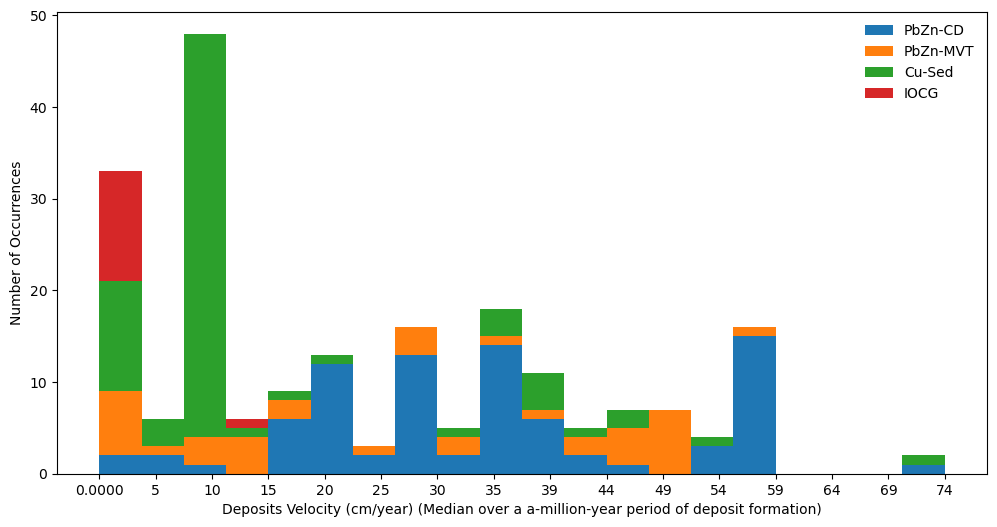

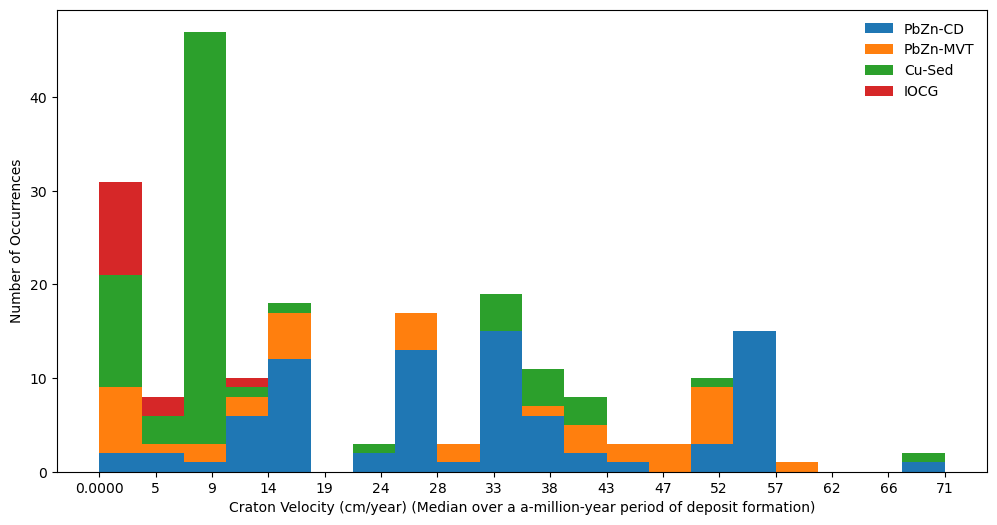

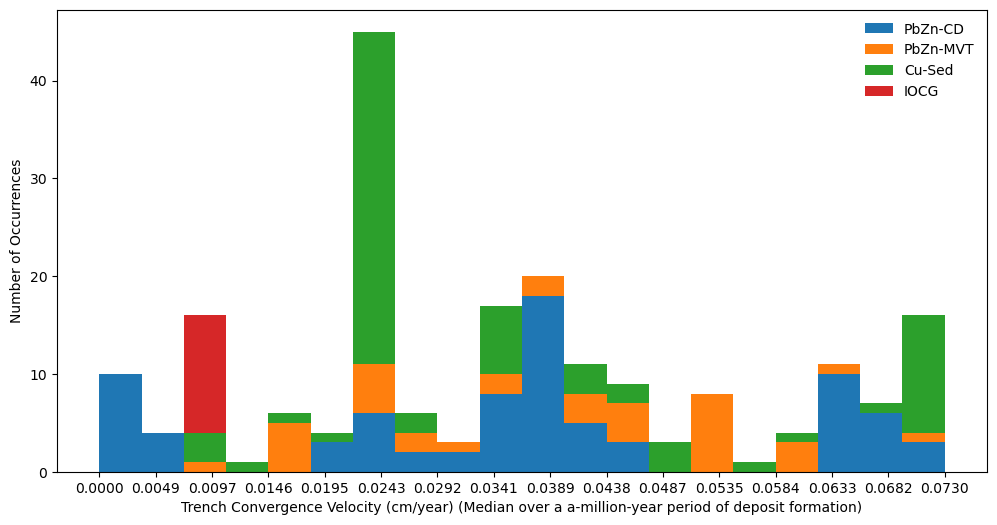

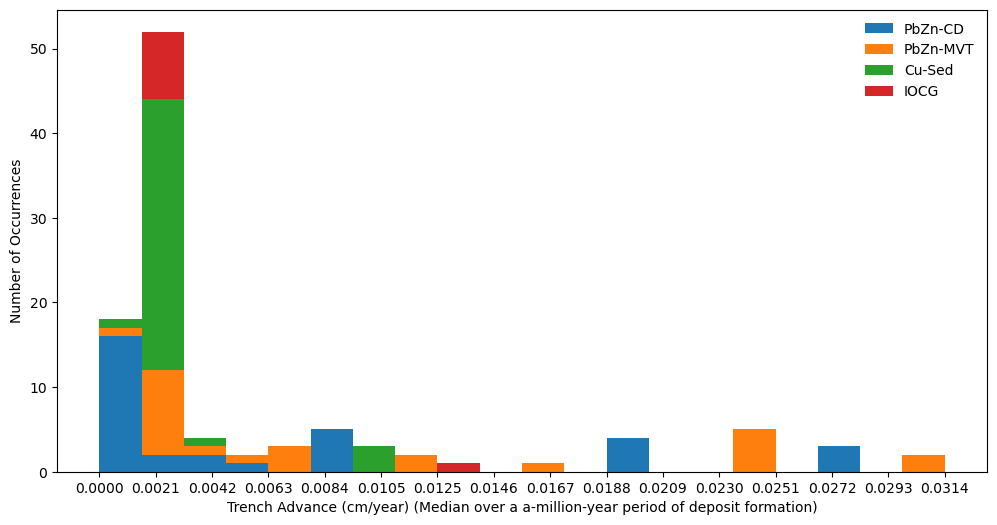

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "dp_ve_m": "Deposits Velocity (cm/year) (Median over a a-million-year period of deposit formation)",
    "cr_ve_m": "Craton Velocity (cm/year) (Median over a a-million-year period of deposit formation)",
    "sb_ve_m": "Trench Convergence Velocity (cm/year) (Median over a a-million-year period of deposit formation)",
    "tr_adv_m": "Trench Advance (cm/year) (Median over a a-million-year period of deposit formation)"
}

# Loop over the variables for plotting
for label in [
    "dp_ve_m",
    "cr_ve_m",
    "sb_ve_m",
    "tr_adv_m",
]:
    # Set the figure size for better visibility
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Number of Occurrences')

    variable_stack = []

    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan values
        df = df.replace(np.inf, np.nan)

        # Get the variable data (without weights)
        variable = df[label].to_numpy()

        variable_stack.append(variable)

        # Calculate vmin and vmax based on 1st and 99th percentiles
        current_vmin = np.nanpercentile(variable, 1)
        current_vmax = np.nanpercentile(variable, 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Ensure vmin is set to 0 (starting x-axis from 0)
    vmin = 0

    # Plot the histogram (without weights)
    ax1.hist(variable_stack, range=(vmin, vmax), stacked=True, bins=20, label=types)

    # Set the step size to create evenly spaced ticks and ensure the ticks start from 0
    step_size = (vmax - vmin) / 15  # Divides the range into 15 equal intervals
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.4f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

    # Place the legend on the upper right without a frame
    ax1.legend(loc="upper right", frameon=False)

# Show the plot for each iteration
plt.show()


## Weighted Histograms

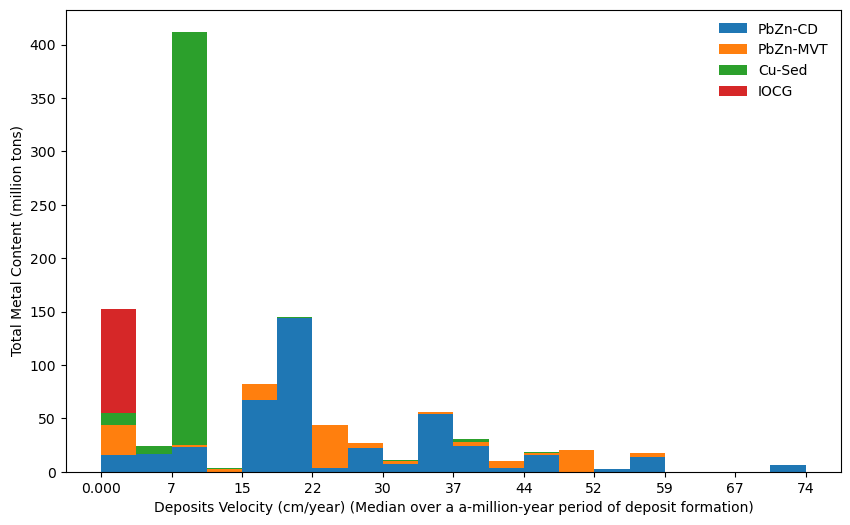

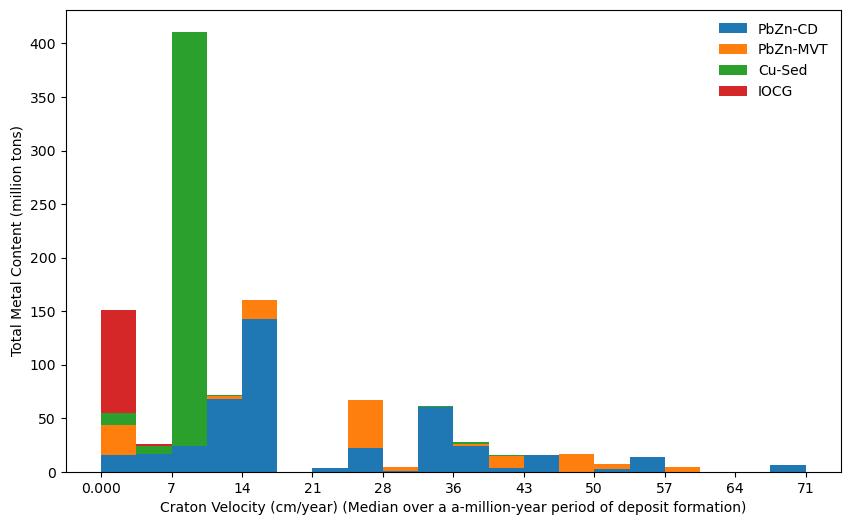

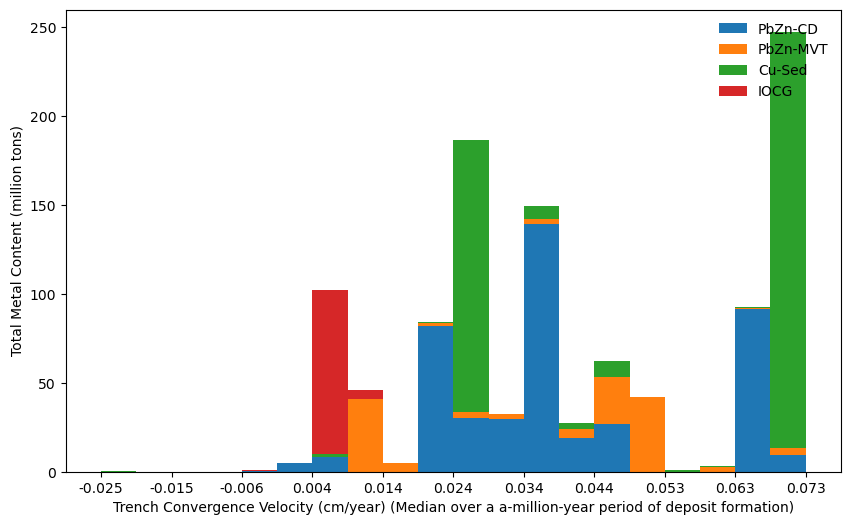

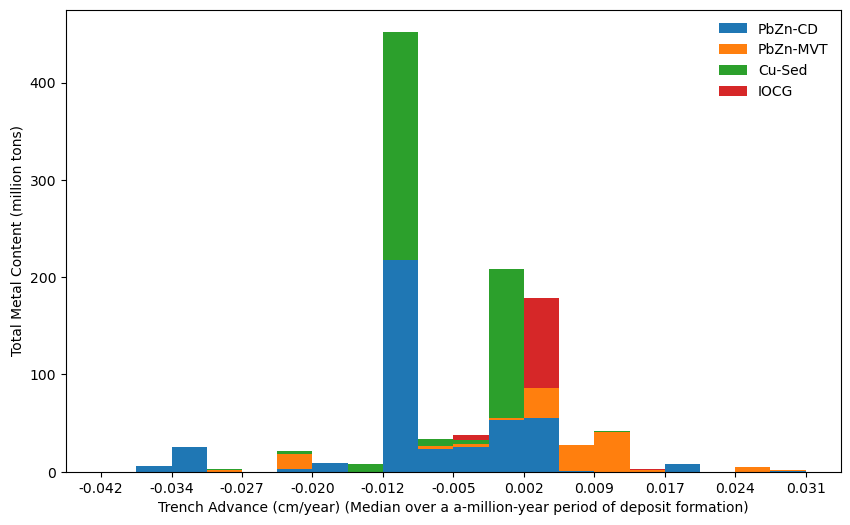

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "dp_ve_m": "Deposits Velocity (cm/year) (Median over a a-million-year period of deposit formation)",
    "cr_ve_m": "Craton Velocity (cm/year) (Median over a a-million-year period of deposit formation)",
    "sb_ve_m": "Trench Convergence Velocity (cm/year) (Median over a a-million-year period of deposit formation)",
    "tr_adv_m": "Trench Advance (cm/year) (Median over a a-million-year period of deposit formation)"
}

# Loop over the variables for plotting
for label in [
    "dp_ve_m",
    "cr_ve_m",
    "sb_ve_m",
    "tr_adv_m",
]:
    # Set the figure size for better visibility
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Total Metal Content (million tons)')

    variable_stack = []
    weight_stack = []

    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan values
        df = df.replace(np.inf, np.nan)

        # Get the variable and weights
        variable = df[label].to_numpy()
        weights = df['TM2'].to_numpy()  # Use TM2 column as weights

        variable_stack.append(variable)
        weight_stack.append(weights)

        # Calculate vmin and vmax based on 1st and 99th percentiles
        current_vmin = np.nanpercentile(variable, 1)
        current_vmax = np.nanpercentile(variable, 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Set vmin to 0 only if all values are positive
    if vmin > 0:
        vmin = 0

    # Plot the weighted histogram
    ax1.hist(variable_stack, range=(vmin, vmax), weights=weight_stack, stacked=True, bins=20, label=types)
    
    # Dynamically calculate the interval based on the data range
    interval = (vmax - vmin) / 10  # Adjust this factor to change the number of ticks
    x_ticks = np.arange(vmin, vmax + interval, step=interval)  # Generate tick positions
    ax1.set_xticks(x_ticks)

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.3f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

    # Place the legend on the upper right without a frame
    ax1.legend(loc="upper right", frameon=False)

# Show the plot for each iteration
plt.show()


## Rose Diagrams (No.)

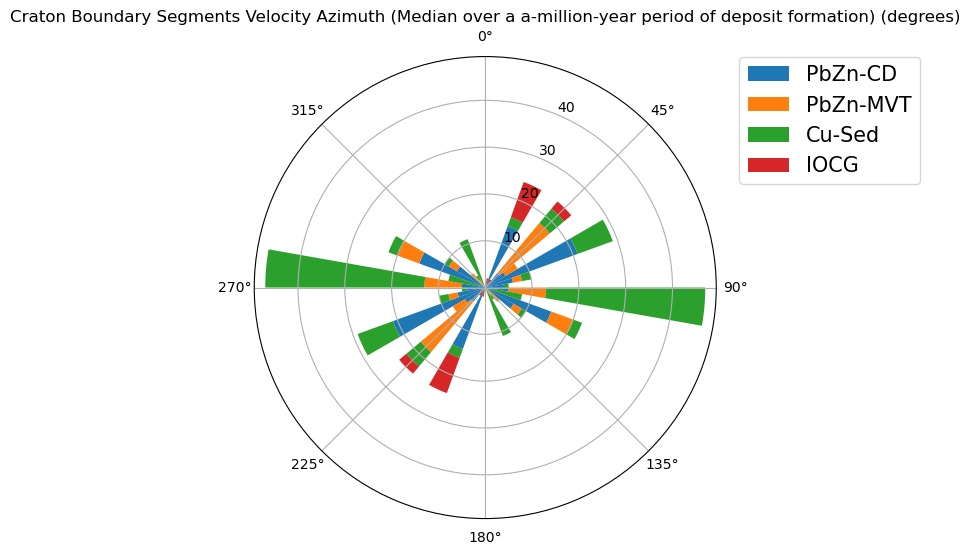

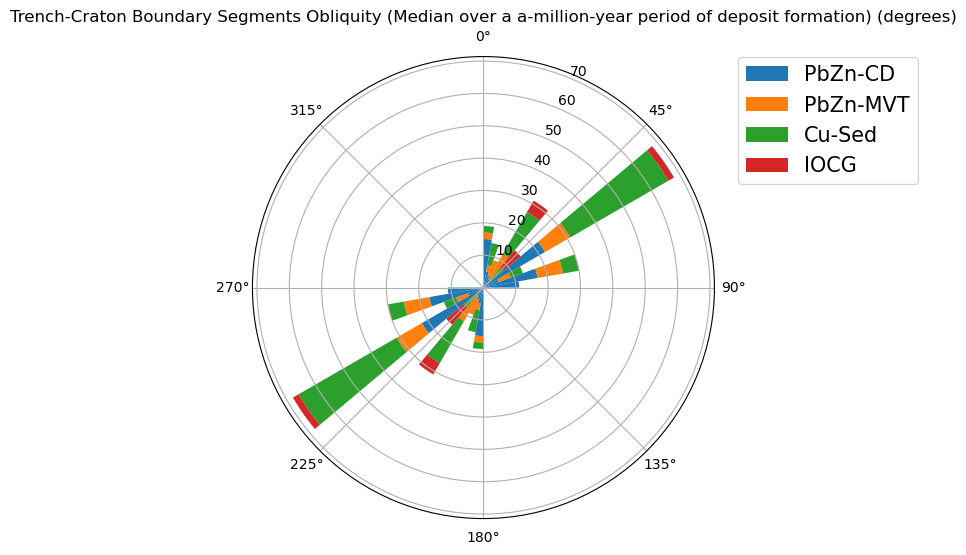

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "cr_ve_az_m": "Craton Boundary Segments Velocity Azimuth (Median over a a-million-year period of deposit formation) (degrees)",
    "tr_cr_an_m": "Trench-Craton Boundary Segments Obliquity (Median over a a-million-year period of deposit formation) (degrees)"
}

# Loop over the variables for plotting
for label in [
    "cr_ve_az_m",
    "tr_cr_an_m",
]:
    # Set the figure size for better visibility
    fig = plt.figure(figsize=(6, 6))  # Adjust the figure size for polar plots
    ax1 = fig.add_subplot(111, polar=True)

    # Set the direction and offset for the polar plot
    ax1.set_theta_direction(-1)
    ax1.set_theta_offset(np.pi / 2.0)

    # Set the title using custom labels
    ax1.set_title(custom_labels[label])

    variable_stack = []

    for type_name in types:
        df = metal_dict[type_name]

        # Extract the azimuths and add 180 to ensure full 0-360 coverage
        azimuths = np.hstack([df[label], df[label] + 180])
        variable_stack.append(np.deg2rad(azimuths))  # Convert azimuths to radians

    # Plot the polar histogram without weights
    ax1.hist(variable_stack, stacked=True, range=(0, np.pi * 2), bins=36, label=types)

    # Place the legend outside the plot
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})  # Adjust legend size

# Show the plot for each iteration
plt.show()


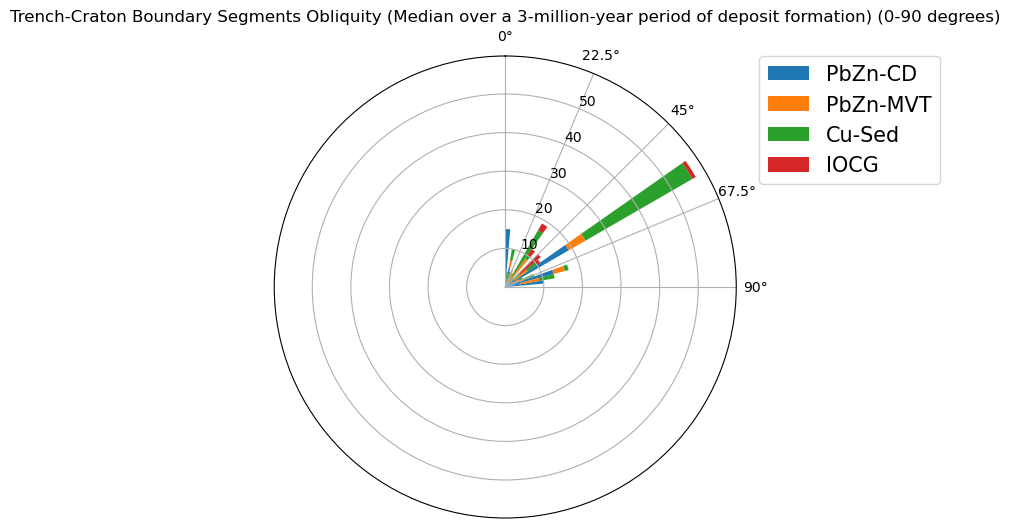

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure and polar subplot
fig = plt.figure(figsize=(6, 6))  # Adjusting figure size for better visibility
ax1 = fig.add_subplot(111, polar=True)

# Set the direction and offset for the polar plot
ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.pi / 2.0)

# Set the title for the polar plot
ax1.set_title('Trench-Craton Boundary Segments Obliquity (Median over a 3-million-year period of deposit formation) (0-90 degrees)')

variable_stack = []

for type_name in types:
    df = metal_dict[type_name]

    # Extract the trench-craton obliquity and clip it between 0 and 90 degrees
    obliquity = df['tr_cr_an_m'].to_numpy()
    obliquity = np.clip(obliquity, 0, 90)  # Ensure values are within 0-90 range
    
    variable_stack.append(np.deg2rad(obliquity))  # Convert to radians

# Plot the polar histogram for obliquity (without weights)
ax1.hist(variable_stack, stacked=True, range=(0, np.pi / 2), bins=18, label=types)

# Set x-ticks for 0, 22.5, 45, 67.5, 90 degrees
ax1.set_xticks(np.linspace(0, np.pi / 2, 5))
ax1.set_xticklabels(['0°', '22.5°', '45°', '67.5°', '90°'])

# Place the legend outside the plot with a specified font size
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})

# Show the plot
plt.show()


## Weighted Rose Diagrams

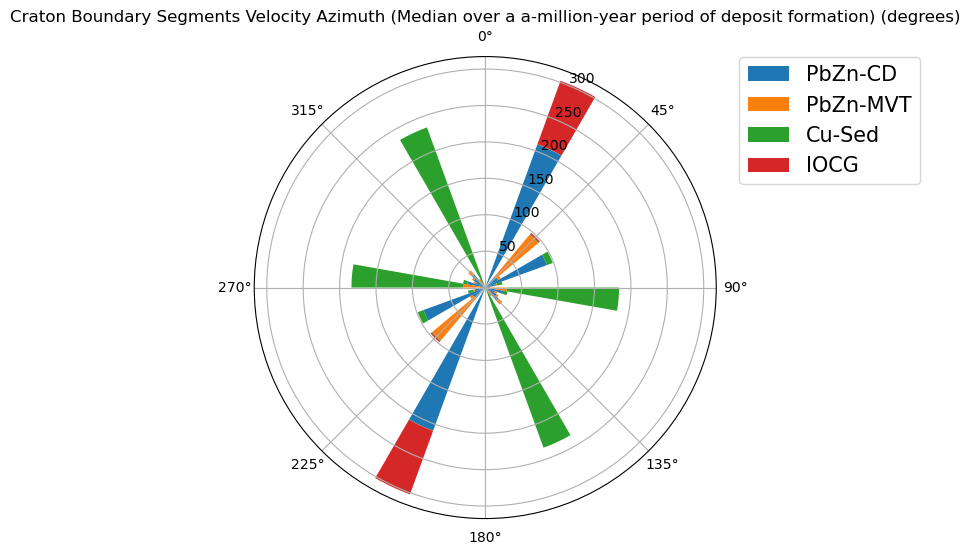

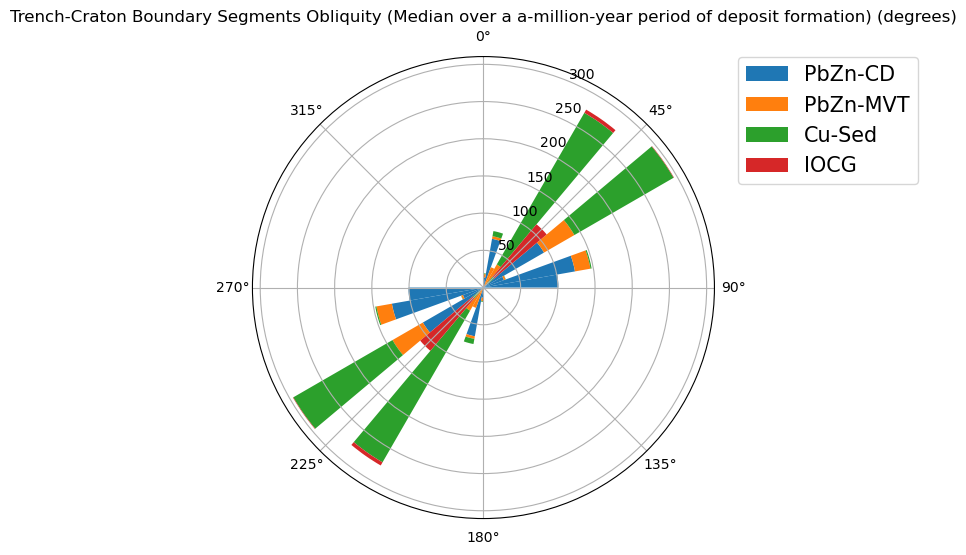

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "cr_ve_az_m": "Craton Boundary Segments Velocity Azimuth (Median over a a-million-year period of deposit formation) (degrees)",
    "tr_cr_an_m": "Trench-Craton Boundary Segments Obliquity (Median over a a-million-year period of deposit formation) (degrees)"
}

# Loop over the variables for plotting
for label in [
    "cr_ve_az_m",
    "tr_cr_an_m",
]:
    # Set the figure size for better visibility
    fig = plt.figure(figsize=(6, 6))  # Adjust the figure size for polar plots
    ax1 = fig.add_subplot(111, polar=True)

    # Set the direction and offset for the polar plot
    ax1.set_theta_direction(-1)
    ax1.set_theta_offset(np.pi / 2.0)

    # Set the title using custom labels
    ax1.set_title(custom_labels[label])

    variable_stack = []
    weight_stack = []

    for type_name in types:
        df = metal_dict[type_name]

        # Extract the azimuths and add 180 to ensure full 0-360 coverage
        azimuths = np.hstack([df[label], df[label] + 180])
        variable_stack.append(np.deg2rad(azimuths))  # Convert azimuths to radians
        
        # Use 'TM2' as weights
        weights = np.hstack([df['TM2'], df['TM2']])  # Same weights for mirrored azimuths
        weight_stack.append(weights)

    # Plot the weighted polar histogram
    ax1.hist(variable_stack, stacked=True, weights=weight_stack, range=(0, np.pi * 2), bins=36, label=types)

    # Place the legend outside the plot
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})  # Adjust legend size

# Show the plot for each iteration
plt.show()


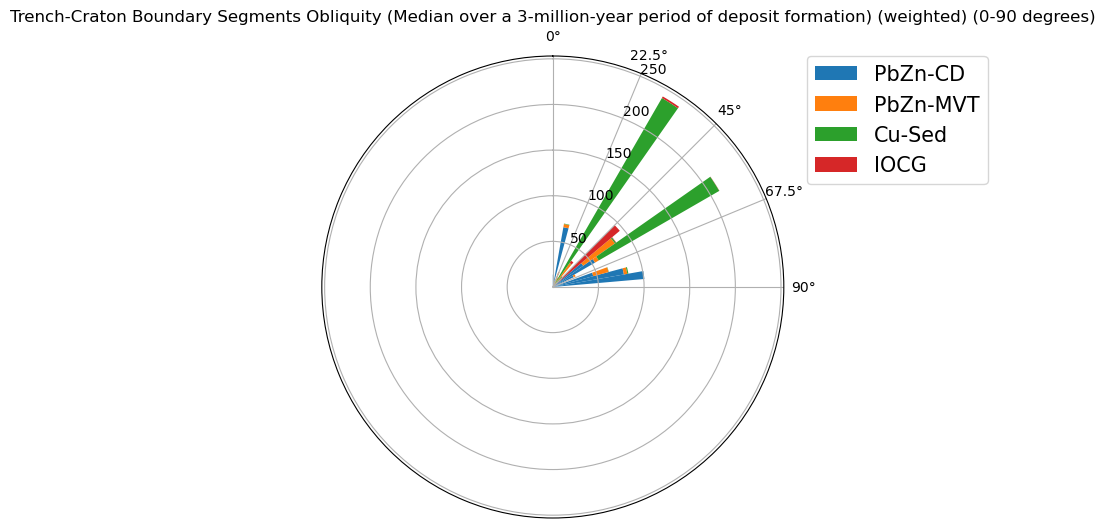

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure and polar subplot
fig = plt.figure(figsize=(6, 6))  # Adjusting figure size for better visibility
ax1 = fig.add_subplot(111, polar=True)

# Set the direction and offset for the polar plot
ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.pi / 2.0)

# Set the title for the polar plot
ax1.set_title('Trench-Craton Boundary Segments Obliquity (Median over a 3-million-year period of deposit formation) (weighted) (0-90 degrees)')

variable_stack = []
weight_stack = []

for type_name in types:
    df = metal_dict[type_name]

    # Extract the trench-craton obliquity and clip it between 0 and 90 degrees
    obliquity = df['tr_cr_an_m'].to_numpy()
    obliquity = np.clip(obliquity, 0, 90)  # Ensure values are within 0-90 range
    
    variable_stack.append(np.deg2rad(obliquity))  # Convert to radians
    
    # Use 'TM2' as weights
    weights = df['TM2'].to_numpy()
    weight_stack.append(weights)

# Plot the weighted polar histogram for obliquity
ax1.hist(variable_stack, stacked=True, weights=weight_stack, range=(0, np.pi / 2), bins=18, label=types)

# Set x-ticks for 0, 22.5, 45, 67.5, 90 degrees
ax1.set_xticks(np.linspace(0, np.pi / 2, 5))
ax1.set_xticklabels(['0°', '22.5°', '45°', '67.5°', '90°'])

# Place the legend outside the plot with a specified font size
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})

# Show the plot
plt.show()


# The Gradient or Change (g-million-year)

## Extracting Plate Tectonic Features (The Gradient)

In [106]:
# for t, time in enumerate(unique_times):
#     # Reconstruct craton features for the current time
#     reconstructed_craton_features = model.reconstruct(Craton_HS_features, time)

#     # Tessellate subduction zones for the current time
#     subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)
#     subduction_lon = subduction_data[:, 0]
#     subduction_lat = subduction_data[:, 1]
#     subduction_vel = subduction_data[:, 2] * 1e-2
#     subduction_angle = subduction_data[:, 3]
#     subduction_norm = subduction_data[:, 7]
#     subduction_convergence = np.fabs(subduction_data[:, 2]) * 1e-2 * np.cos(np.radians(subduction_data[:, 3]))
#     subduction_migration = np.fabs(subduction_data[:, 4]) * 1e-2 * np.cos(np.radians(subduction_data[:, 5]))

#     # Convert lon/lat to xyz coordinates for subduction zones
#     sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
#     tree_sz = cKDTree(np.c_[sx, sy, sz])

#     # Get craton centroids and build KDTree for craton search
#     craton_centroids = np.empty((len(reconstructed_craton_features), 2))
#     for f, feature in enumerate(reconstructed_craton_features):
#         geometry = feature.get_reconstructed_geometry()
#         craton_centroids[f, :] = geometry.get_centroid().to_lat_lon()

#     # Convert craton centroids to xyz coordinates for KDTree search
#     cx, cy, cz = gplately.tools.lonlat2xyz(craton_centroids[:, 1], craton_centroids[:, 0])
#     tree_craton = cKDTree(np.c_[cx, cy, cz])  # Create KDTree for nearest craton search

#     # Iterate over each mineral type
#     for type_name in types:
#         df = metal_dict[type_name]
#         deposit_age = df['Age'].to_numpy(dtype=int)
#         mask_deposit_ages = deposit_age == time
#         index_deposit_age = df.index[mask_deposit_ages]

#         if not index_deposit_age.any():
#             continue

#         gpts = pts_dict[type_name]
#         rlons, rlats = gpts.reconstruct(time, return_array=True)

#         # Apply strict validation for latitude and longitude values
#         valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)

#         # Filter valid latitudes and longitudes
#         rlons = rlons[valid_mask]
#         rlats = rlats[valid_mask]

#         if len(rlons) == 0 or len(rlats) == 0:
#             print(f"No valid lat/lon points for {type_name} at time {time}")
#             continue

#         # Initialize lists to store values for each year
#         deposit_velocity_vals = []
#         craton_velocity_vals = []
#         craton_velocity_azimuth_vals = []
#         trench_craton_obliquity_vals = []
#         trench_convergence_vals = []  # NEW LIST
#         trench_advance_vals = []      # NEW LIST

#         # Loop for the 4 years to calculate gradients
#         for year_offset in range(4):  # To calculate gradients, we need 4 years (including the current)
#             avg_time = time - year_offset
#             gpts = pts_dict[type_name]
#             rlons, rlats = gpts.reconstruct(avg_time, return_array=True)

#             valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)
#             rlons = rlons[valid_mask]
#             rlats = rlats[valid_mask]

#             if len(rlons) == 0 or len(rlats) == 0:
#                 print(f"No valid lat/lon points for {type_name} at time {avg_time}")
#                 continue

#             # Calculate deposit velocities
#             deposit_velocity_components = model.get_point_velocities(rlons, rlats, avg_time)
#             deposit_velocity_magnitude = np.hypot(deposit_velocity_components[:, 0], deposit_velocity_components[:, 1])
#             deposit_velocity_vals.append(deposit_velocity_magnitude.mean())

#             # Convert deposit lon/lat to xyz coordinates
#             deposit_xyz = np.c_[gplately.tools.lonlat2xyz(rlons, rlats)]

#             # Find the nearest subduction zone segment for each deposit
#             d2sz, sz_neighbours = tree_sz.query(deposit_xyz)  # Get closest subduction zone

#             # Calculate subduction zone properties
#             sz_norm = subduction_norm[sz_neighbours].copy()
#             sz_norm[sz_norm > 180] -= 180

#             # Find the nearest craton segment for each deposit
#             d2craton, craton_neighbours = tree_craton.query(deposit_xyz)  # Get closest craton

#             # Calculate craton velocities and azimuth
#             craton_velocity_components = model.get_point_velocities(
#                 craton_centroids[craton_neighbours, 1], craton_centroids[craton_neighbours, 0], avg_time
#             )
#             craton_velocity_magnitude = np.hypot(craton_velocity_components[:, 0], craton_velocity_components[:, 1])
#             craton_velocity_angle = np.rad2deg(np.arctan2(craton_velocity_components[:, 0], craton_velocity_components[:, 1]))
#             craton_velocity_angle[craton_velocity_angle < 0] += 180

#             craton_velocity_vals.append(craton_velocity_magnitude.mean())
#             craton_velocity_azimuth_vals.append(craton_velocity_angle.mean())

#             # Calculate obliquity between the craton and the subduction zone
#             sz_obliquity = abs(sz_norm.mean() - craton_velocity_angle.mean()) % 180
#             if sz_obliquity > 90:
#                 sz_obliquity = 180 - sz_obliquity

#             trench_craton_obliquity_vals.append(sz_obliquity)

#             # Add subduction convergence and migration (trench advance) values for the closest subduction zone
#             trench_convergence_vals.append(subduction_convergence[sz_neighbours].mean())
#             trench_advance_vals.append(subduction_migration[sz_neighbours].mean())

#         # Calculate gradients from a to 0 years
#         if len(deposit_velocity_vals) >= a+1:
#             deposit_velocity_gradient_a_0 = (deposit_velocity_vals[a] - deposit_velocity_vals[0]) / 1
#             craton_velocity_gradient_a_0 = (craton_velocity_vals[a] - craton_velocity_vals[0]) / 1
#             craton_velocity_azimuth_gradient_a_0 = (craton_velocity_azimuth_vals[a] - craton_velocity_azimuth_vals[0]) / 1
#             trench_craton_obliquity_gradient_a_0 = (trench_craton_obliquity_vals[a] - trench_craton_obliquity_vals[0]) / 1
#             trench_convergence_gradient_a_0 = (trench_convergence_vals[a] - trench_convergence_vals[0]) / 1  # NEW
#             trench_advance_gradient_a_0 = (trench_advance_vals[a] - trench_advance_vals[0]) / 1  # NEW

#             # Update DataFrame with gradients
#             df.loc[index_deposit_age, 'deposit_velocity_gradient_a_0'] = deposit_velocity_gradient_a_0
#             df.loc[index_deposit_age, 'craton_velocity_gradient_a_0'] = craton_velocity_gradient_a_0
#             df.loc[index_deposit_age, 'craton_velocity_azimuth_gradient_a_0'] = craton_velocity_azimuth_gradient_a_0
#             df.loc[index_deposit_age, 'trench_craton_obliquity_gradient_a_0'] = trench_craton_obliquity_gradient_a_0
#             df.loc[index_deposit_age, 'trench_convergence_gradient_a_0'] = trench_convergence_gradient_a_0  # NEW
#             df.loc[index_deposit_age, 'trench_advance_gradient_a_0'] = trench_advance_gradient_a_0  # NEW

#     # Update progress
#     gplately.tools.update_progress((t + 1) / len(unique_times))


In [107]:
# change the year 

In [108]:
g = 20
for t, time in enumerate(unique_times):
    # Reconstruct craton features for the current time
    reconstructed_craton_features = model.reconstruct(Craton_HS_features, time)

    # Tessellate subduction zones for the current time
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)
    subduction_lon = subduction_data[:, 0]
    subduction_lat = subduction_data[:, 1]
    subduction_vel = subduction_data[:, 2] * 1e-2
    subduction_angle = subduction_data[:, 3]
    subduction_norm = subduction_data[:, 7]
    subduction_convergence = np.fabs(subduction_data[:, 2]) * 1e-2 * np.cos(np.radians(subduction_data[:, 3]))
    subduction_migration = np.fabs(subduction_data[:, 4]) * 1e-2 * np.cos(np.radians(subduction_data[:, 5]))

    # Convert lon/lat to xyz coordinates for subduction zones
    sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
    tree_sz = cKDTree(np.c_[sx, sy, sz])

    # Get craton centroids and build KDTree for craton search
    craton_centroids = np.empty((len(reconstructed_craton_features), 2))
    for f, feature in enumerate(reconstructed_craton_features):
        geometry = feature.get_reconstructed_geometry()
        craton_centroids[f, :] = geometry.get_centroid().to_lat_lon()

    # Convert craton centroids to xyz coordinates for KDTree search
    cx, cy, cz = gplately.tools.lonlat2xyz(craton_centroids[:, 1], craton_centroids[:, 0])
    tree_craton = cKDTree(np.c_[cx, cy, cz])  # Create KDTree for nearest craton search

    # Iterate over each mineral type
    for type_name in types:
        df = metal_dict[type_name]
        deposit_age = df['Age'].to_numpy(dtype=int)
        mask_deposit_ages = deposit_age == time
        index_deposit_age = df.index[mask_deposit_ages]

        if not index_deposit_age.any():
            continue

        gpts = pts_dict[type_name]
        rlons, rlats = gpts.reconstruct(time, return_array=True)

        # Apply strict validation for latitude and longitude values
        valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)

        # Filter valid latitudes and longitudes
        rlons = rlons[valid_mask]
        rlats = rlats[valid_mask]

        if len(rlons) == 0 or len(rlats) == 0:
            print(f"No valid lat/lon points for {type_name} at time {time}")
            continue

        # Initialize lists to store values for each year
        deposit_velocity_vals = []
        craton_velocity_vals = []
        craton_velocity_azimuth_vals = []
        trench_craton_obliquity_vals = []
        trench_convergence_vals = []  # NEW LIST
        trench_advance_vals = []      # NEW LIST

        # Loop for the g+1 years to calculate gradients
        for year_offset in range(g + 1):  # To calculate gradients, we need g+1 years (including the current)
            avg_time = time - year_offset
            gpts = pts_dict[type_name]
            rlons, rlats = gpts.reconstruct(avg_time, return_array=True)

            valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)
            rlons = rlons[valid_mask]
            rlats = rlats[valid_mask]

            if len(rlons) == 0 or len(rlats) == 0:
                print(f"No valid lat/lon points for {type_name} at time {avg_time}")
                continue

            # Calculate deposit velocities
            deposit_velocity_components = model.get_point_velocities(rlons, rlats, avg_time)
            deposit_velocity_magnitude = np.hypot(deposit_velocity_components[:, 0], deposit_velocity_components[:, 1])
            deposit_velocity_vals.append(deposit_velocity_magnitude.mean())

            # Convert deposit lon/lat to xyz coordinates
            deposit_xyz = np.c_[gplately.tools.lonlat2xyz(rlons, rlats)]

            # Find the nearest subduction zone segment for each deposit
            d2sz, sz_neighbours = tree_sz.query(deposit_xyz)  # Get closest subduction zone

            # Calculate subduction zone properties
            sz_norm = subduction_norm[sz_neighbours].copy()
            sz_norm[sz_norm > 180] -= 180

            # Find the nearest craton segment for each deposit
            d2craton, craton_neighbours = tree_craton.query(deposit_xyz)  # Get closest craton

            # Calculate craton velocities and azimuth
            craton_velocity_components = model.get_point_velocities(
                craton_centroids[craton_neighbours, 1], craton_centroids[craton_neighbours, 0], avg_time
            )
            craton_velocity_magnitude = np.hypot(craton_velocity_components[:, 0], craton_velocity_components[:, 1])
            craton_velocity_angle = np.rad2deg(np.arctan2(craton_velocity_components[:, 0], craton_velocity_components[:, 1]))
            craton_velocity_angle[craton_velocity_angle < 0] += 180

            craton_velocity_vals.append(craton_velocity_magnitude.mean())
            craton_velocity_azimuth_vals.append(craton_velocity_angle.mean())

            # Calculate obliquity between the craton and the subduction zone
            sz_obliquity = abs(sz_norm.mean() - craton_velocity_angle.mean()) % 180
            if sz_obliquity > 90:
                sz_obliquity = 180 - sz_obliquity

            trench_craton_obliquity_vals.append(sz_obliquity)

            # Add subduction convergence and migration (trench advance) values for the closest subduction zone
            trench_convergence_vals.append(subduction_convergence[sz_neighbours].mean())
            trench_advance_vals.append(subduction_migration[sz_neighbours].mean())

        # Calculate gradients from g to 0 years
        if len(deposit_velocity_vals) >= g+1:
            deposit_velocity_gradient_g_0 = (deposit_velocity_vals[g] - deposit_velocity_vals[0]) / 1
            craton_velocity_gradient_g_0 = (craton_velocity_vals[g] - craton_velocity_vals[0]) / 1
            craton_velocity_azimuth_gradient_g_0 = (craton_velocity_azimuth_vals[g] - craton_velocity_azimuth_vals[0]) / 1
            trench_craton_obliquity_gradient_g_0 = (trench_craton_obliquity_vals[g] - trench_craton_obliquity_vals[0]) / 1
            trench_convergence_gradient_g_0 = (trench_convergence_vals[g] - trench_convergence_vals[0]) / 1  # NEW
            trench_advance_gradient_g_0 = (trench_advance_vals[g] - trench_advance_vals[0]) / 1  # NEW

            # Update DataFrame with gradients
            df.loc[index_deposit_age, 'dp_ve_g'] = deposit_velocity_gradient_g_0
            df.loc[index_deposit_age, 'cr_ve_g'] = craton_velocity_gradient_g_0
            df.loc[index_deposit_age, 'cr_ve_az_c'] = craton_velocity_azimuth_gradient_g_0
            df.loc[index_deposit_age, 'tr_cr_an_c'] = trench_craton_obliquity_gradient_g_0
            df.loc[index_deposit_age, 'sb_ve_g'] = trench_convergence_gradient_g_0  # NEW
            df.loc[index_deposit_age, 'tr_adv_g'] = trench_advance_gradient_g_0  # NEW

    # Update progress
    gplately.tools.update_progress((t + 1) / len(unique_times))


Progress: [####################] 100.0%


## Histograms

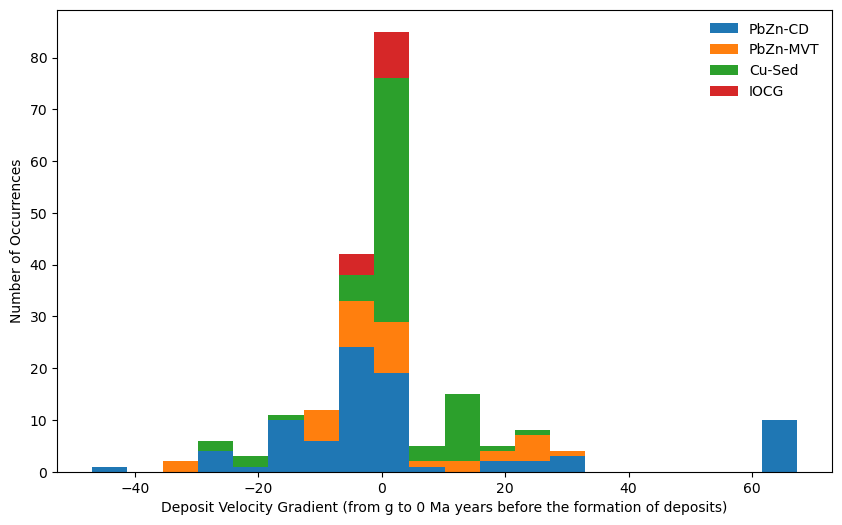

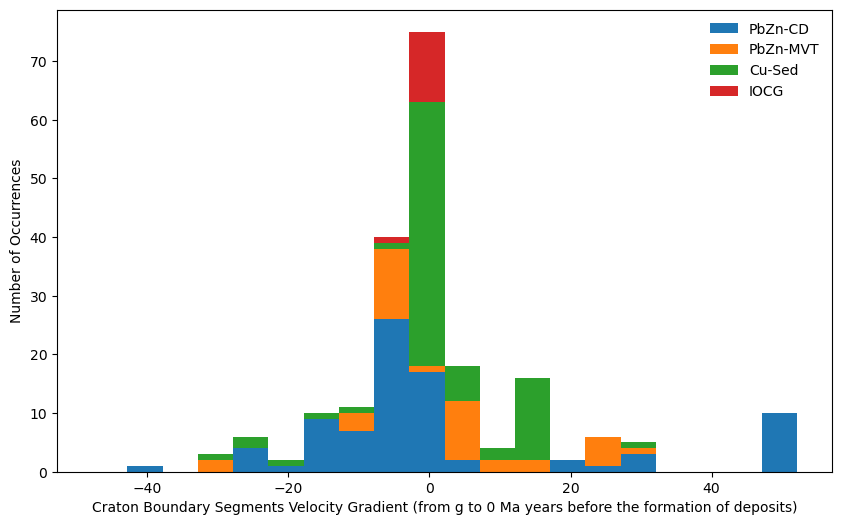

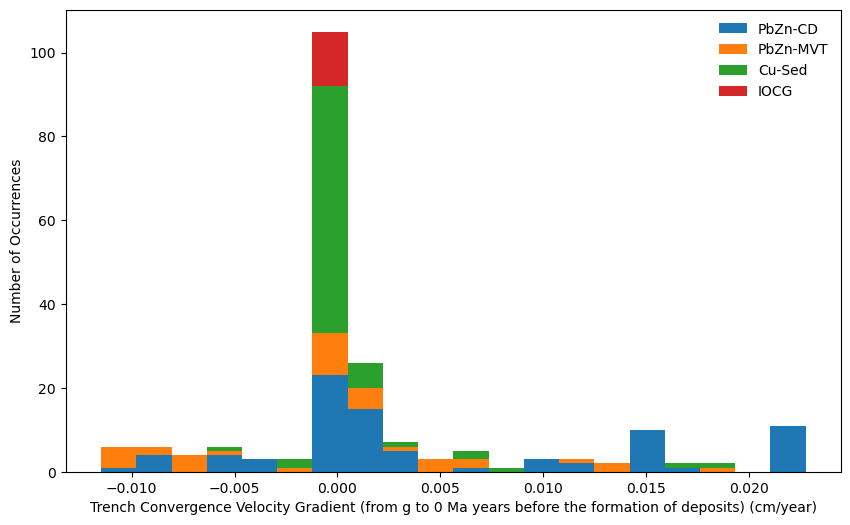

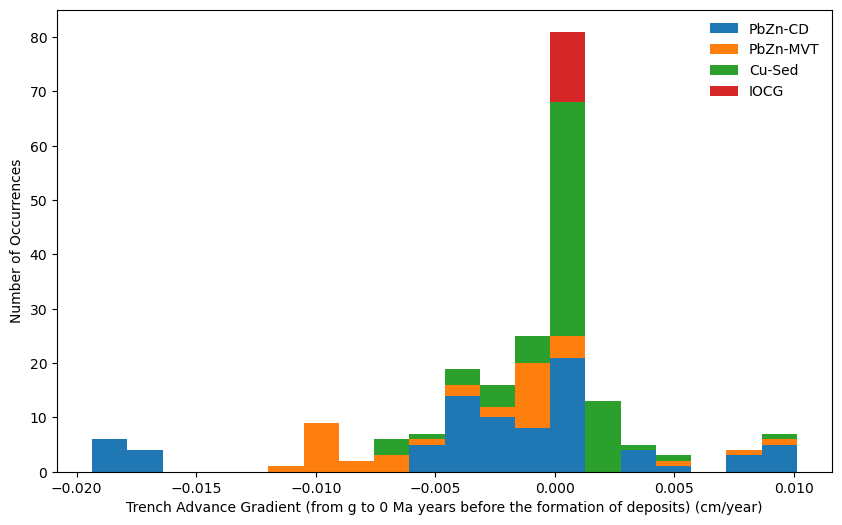

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "dp_ve_g": "Deposit Velocity Gradient (from g to 0 Ma years before the formation of deposits)",
    "cr_ve_g": "Craton Boundary Segments Velocity Gradient (from g to 0 Ma years before the formation of deposits)",
    "sb_ve_g": "Trench Convergence Velocity Gradient (from g to 0 Ma years before the formation of deposits) (cm/year)",
    "tr_adv_g": "Trench Advance Gradient (from g to 0 Ma years before the formation of deposits) (cm/year)"
}

# Loop over the variables for plotting
for label in [
    "dp_ve_g",
    "cr_ve_g",
    "sb_ve_g",
    "tr_adv_g",
]:
    # Set the figure size for better visibility
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Number of Occurrences')

    variable_stack = []

    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan values
        df = df.replace(np.inf, np.nan)

        # Get the variable data (without weights)
        variable = df[label].to_numpy()

        variable_stack.append(variable)

        # Calculate vmin and vmax based on 1st and 99th percentiles
        current_vmin = np.nanpercentile(variable, 1)
        current_vmax = np.nanpercentile(variable, 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Plot the histogram (without weights)
    ax1.hist(variable_stack, range=(vmin, vmax), stacked=True, bins=20, label=types)

    # Set the legend in the upper right without a frame
    ax1.legend(loc="upper right", frameon=False)

# Show the plot for each iteration
plt.show()


## Weighted Histograms

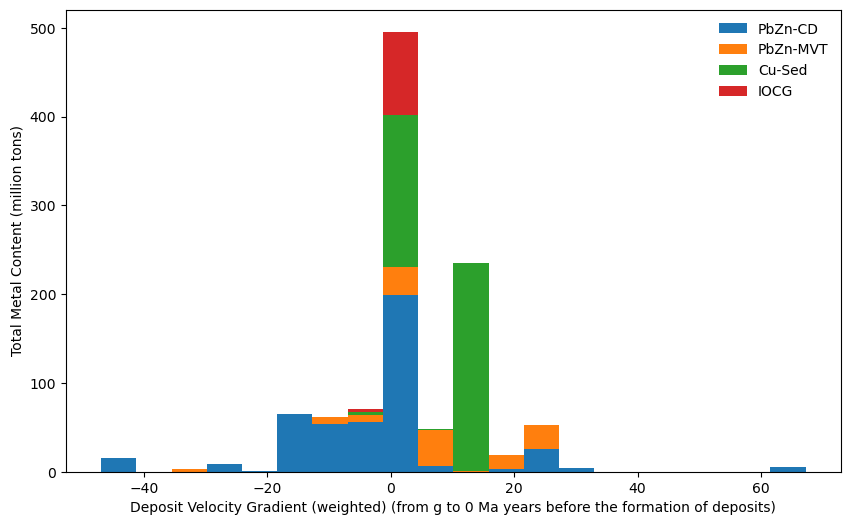

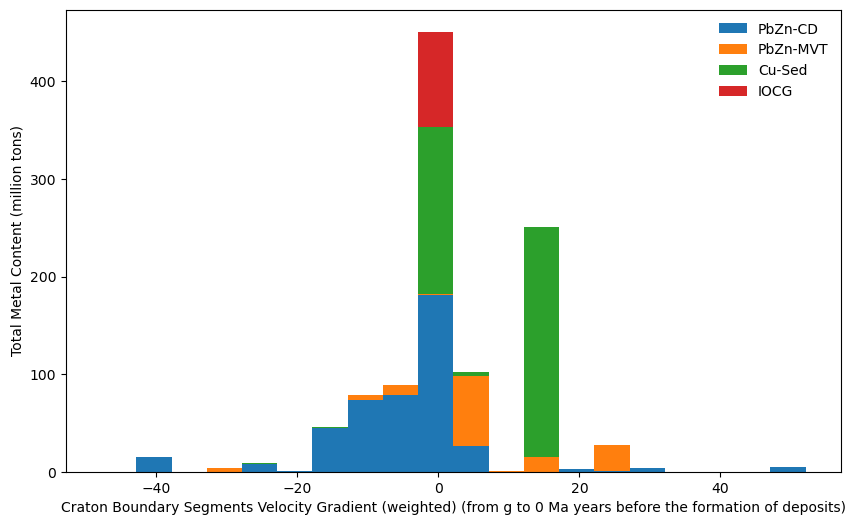

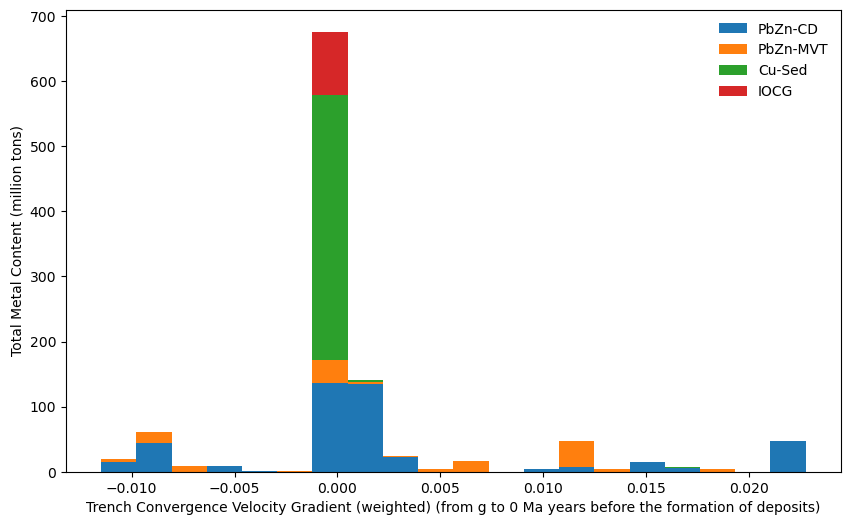

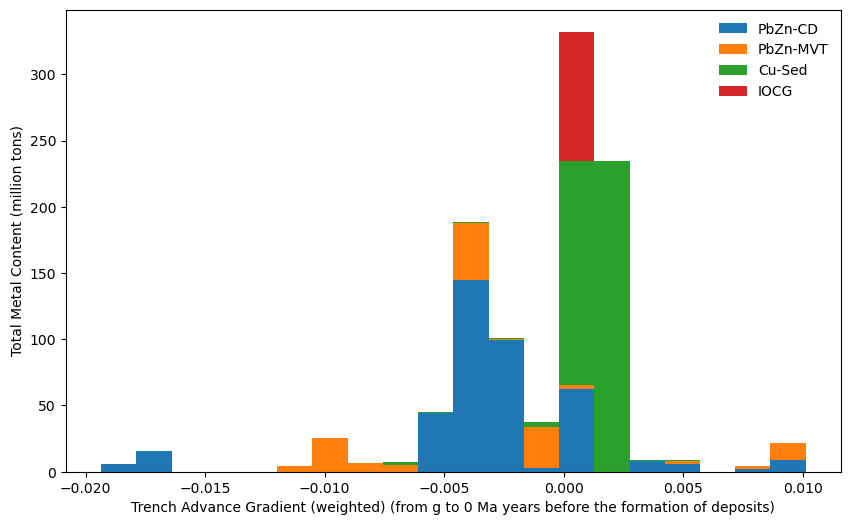

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "dp_ve_g": "Deposit Velocity Gradient (weighted) (from g to 0 Ma years before the formation of deposits)",
    "cr_ve_g": "Craton Boundary Segments Velocity Gradient (weighted) (from g to 0 Ma years before the formation of deposits)",
    "sb_ve_g": "Trench Convergence Velocity Gradient (weighted) (from g to 0 Ma years before the formation of deposits)",
    "tr_adv_g": "Trench Advance Gradient (weighted) (from g to 0 Ma years before the formation of deposits)"
}

# Loop over the variables for plotting
for label in [
    "dp_ve_g",
    "cr_ve_g",
    "sb_ve_g",
    "tr_adv_g"
]:
    # Set the figure size for better visibility
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Total Metal Content (million tons)')

    variable_stack = []
    weight_stack = []

    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan values
        df = df.replace(np.inf, np.nan)

        # Get the variable and weights
        variable = df[label].to_numpy()
        weights = df['TM2'].to_numpy()  # Use TM2 column as weights

        variable_stack.append(variable)
        weight_stack.append(weights)

        # Calculate vmin and vmax based on 1st and 99th percentiles
        current_vmin = np.nanpercentile(variable, 1)
        current_vmax = np.nanpercentile(variable, 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Plot the weighted histogram
    ax1.hist(variable_stack, range=(vmin, vmax), weights=weight_stack, stacked=True, bins=20, label=types)
    
    # Set the legend in the upper right without a frame
    ax1.legend(loc="upper right", frameon=False)

# Show the plot for each iteration
plt.show()


## Rose diagram

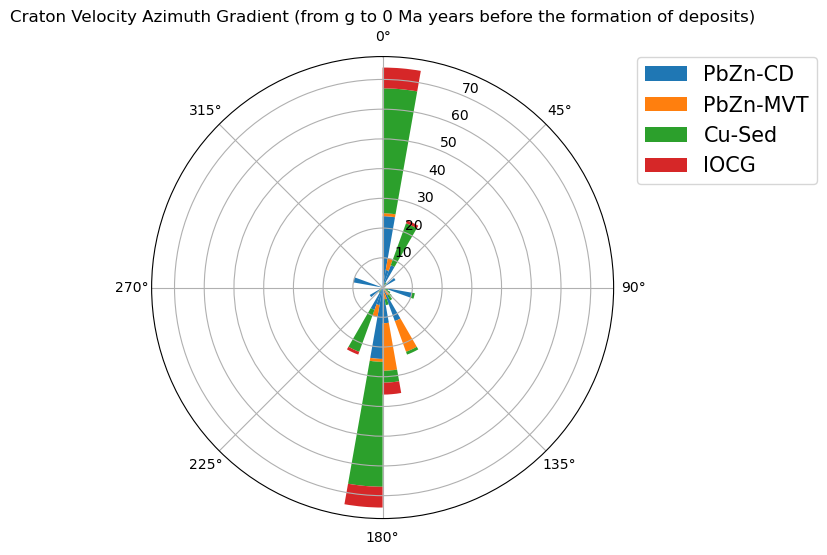

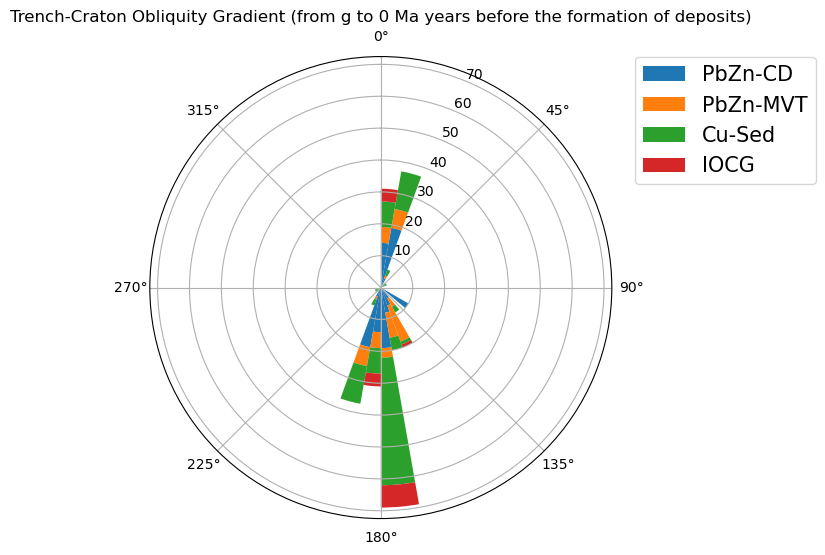

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "cr_ve_az_c": "Craton Velocity Azimuth Gradient (from g to 0 Ma years before the formation of deposits)",
    "tr_cr_an_c": "Trench-Craton Obliquity Gradient (from g to 0 Ma years before the formation of deposits)"
}

# Loop over the variables for plotting
for label in [
    "cr_ve_az_c",
    "tr_cr_an_c",
]:
    # Set the figure size for better visibility
    fig = plt.figure(figsize=(6, 6))  # Adjust the figure size for polar plots
    ax1 = fig.add_subplot(111, polar=True)

    # Set the direction and offset for the polar plot
    ax1.set_theta_direction(-1)
    ax1.set_theta_offset(np.pi / 2.0)

    # Set the title using custom labels
    ax1.set_title(custom_labels[label])

    variable_stack = []

    for type_name in types:
        df = metal_dict[type_name]

        # Extract the azimuths and add 180 to ensure full 0-360 coverage
        azimuths = np.hstack([df[label], df[label] + 180])
        variable_stack.append(np.deg2rad(azimuths))  # Convert azimuths to radians

    # Plot the polar histogram (without weights)
    ax1.hist(variable_stack, stacked=True, range=(0, np.pi * 2), bins=36, label=types)

    # Place the legend outside the plot with a larger font size
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})  # Adjust legend size

# Show the plot for each iteration
plt.show()


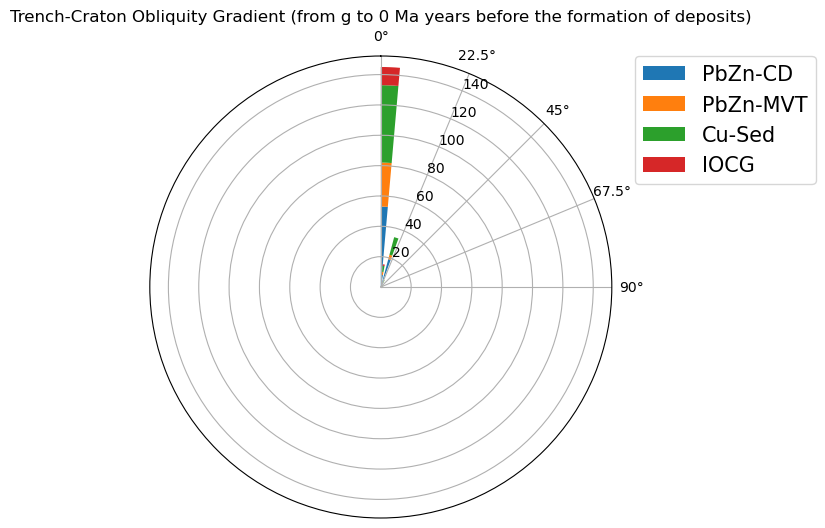

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure and polar subplot
fig = plt.figure(figsize=(6, 6))  # Adjusting figure size for better visibility
ax1 = fig.add_subplot(111, polar=True)

# Set the direction and offset for the polar plot
ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.pi / 2.0)

# Set the title for the polar plot
ax1.set_title('Trench-Craton Obliquity Gradient (from g to 0 Ma years before the formation of deposits)')

variable_stack = []

for type_name in types:
    df = metal_dict[type_name]

    # Extract the trench-craton obliquity and clip it between 0 and 90 degrees
    obliquity = df['tr_cr_an_c'].to_numpy()
    obliquity = np.clip(obliquity, 0, 90)  # Ensure values are within 0-90 range
    
    variable_stack.append(np.deg2rad(obliquity))  # Convert to radians

# Plot the polar histogram for obliquity (without weights)
ax1.hist(variable_stack, stacked=True, range=(0, np.pi / 2), bins=18, label=types)

# Set x-ticks for 0, 22.5, 45, 67.5, 90 degrees
ax1.set_xticks(np.linspace(0, np.pi / 2, 5))
ax1.set_xticklabels(['0°', '22.5°', '45°', '67.5°', '90°'])

# Place the legend outside the plot with a specified font size
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})

# Show the plot
plt.show()


## Weighted rose diagram

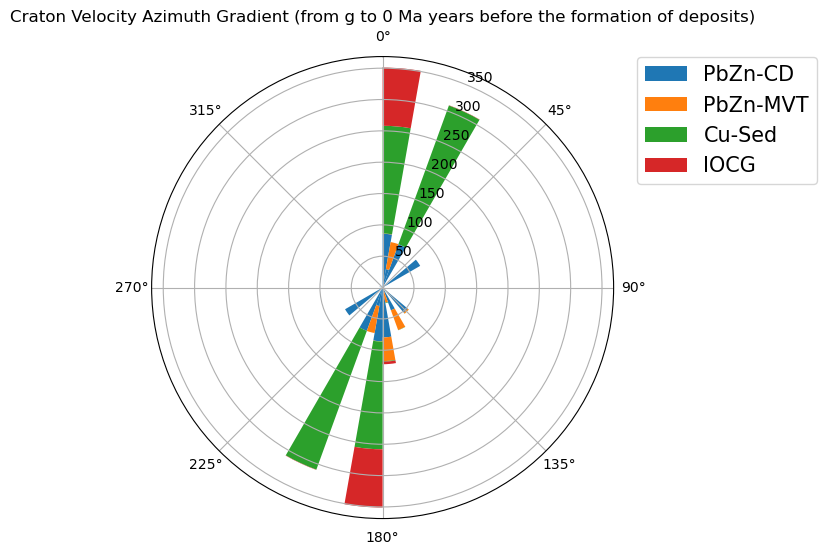

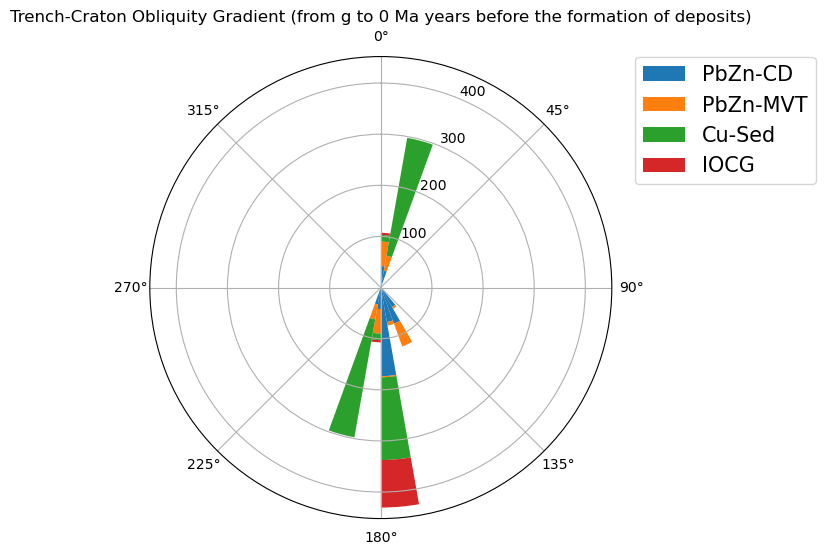

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "cr_ve_az_c": "Craton Velocity Azimuth Gradient (from g to 0 Ma years before the formation of deposits)",
    "tr_cr_an_c": "Trench-Craton Obliquity Gradient (from g to 0 Ma years before the formation of deposits)"
}

# Loop over the variables for plotting
for label in [
    "cr_ve_az_c",
    "tr_cr_an_c",
]:
    # Set the figure size for better visibility
    fig = plt.figure(figsize=(6, 6))  # Adjust the figure size for polar plots
    ax1 = fig.add_subplot(111, polar=True)

    # Set the direction and offset for the polar plot
    ax1.set_theta_direction(-1)
    ax1.set_theta_offset(np.pi / 2.0)

    # Set the title using custom labels
    ax1.set_title(custom_labels[label])

    variable_stack = []
    weight_stack = []

    for type_name in types:
        df = metal_dict[type_name]

        # Extract the azimuths and add 180 to ensure full 0-360 coverage
        azimuths = np.hstack([df[label], df[label] + 180])
        variable_stack.append(np.deg2rad(azimuths))  # Convert azimuths to radians
        
        # Use 'TM2' as weights
        weights = np.hstack([df['TM2'], df['TM2']])  # Same weights for mirrored azimuths
        weight_stack.append(weights)

    # Plot the weighted polar histogram
    ax1.hist(variable_stack, stacked=True, weights=weight_stack, range=(0, np.pi * 2), bins=36, label=types)

    # Place the legend outside the plot with a larger font size
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})  # Adjust legend size

# Show the plot for each iteration
plt.show()


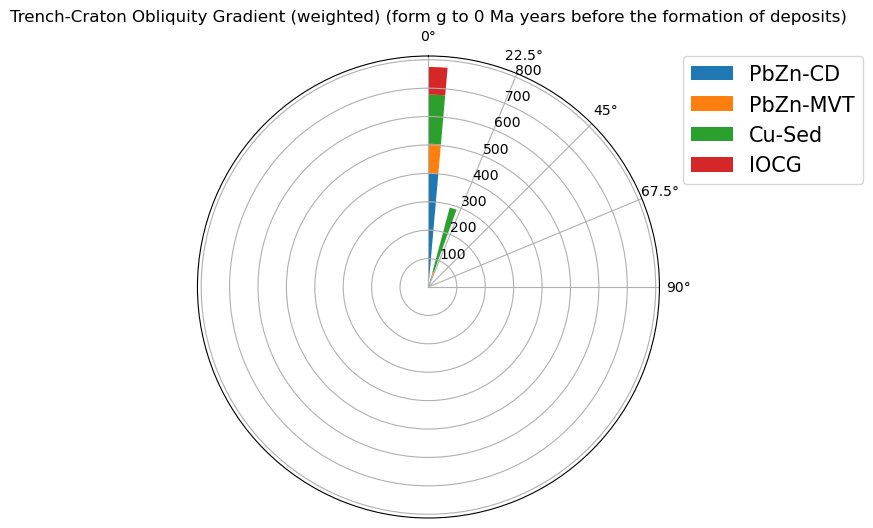

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure and polar subplot
fig = plt.figure(figsize=(6, 6))  # Adjusting figure size for better visibility
ax1 = fig.add_subplot(111, polar=True)

# Set the direction and offset for the polar plot
ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.pi / 2.0)

# Set the title for the polar plot
ax1.set_title('Trench-Craton Obliquity Gradient (weighted) (form g to 0 Ma years before the formation of deposits)')

variable_stack = []
weight_stack = []

for type_name in types:
    df = metal_dict[type_name]

    # Extract the trench-craton obliquity and clip it between 0 and 90 degrees
    obliquity = df['tr_cr_an_c'].to_numpy()
    obliquity = np.clip(obliquity, 0, 90)  # Ensure values are within 0-90 range
    
    variable_stack.append(np.deg2rad(obliquity))  # Convert to radians
    
    # Use 'TM2' as weights
    weights = df['TM2'].to_numpy()
    weight_stack.append(weights)

# Plot the weighted polar histogram for obliquity
ax1.hist(variable_stack, stacked=True, weights=weight_stack, range=(0, np.pi / 2), bins=18, label=types)

# Set x-ticks for 0, 22.5, 45, 67.5, 90 degrees
ax1.set_xticks(np.linspace(0, np.pi / 2, 5))
ax1.set_xticklabels(['0°', '22.5°', '45°', '67.5°', '90°'])

# Place the legend outside the plot with a specified font size
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 15})

# Show the plot
plt.show()


# 'rlat' and 'rlon' values for the deposits

In [115]:
for t, time in enumerate(unique_times):
    # Reconstruct craton features for the current time
    reconstructed_craton_features = model.reconstruct(Craton_HS_features, time)

    # Tessellate subduction zones for the current time
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)
    subduction_lon = subduction_data[:, 0]
    subduction_lat = subduction_data[:, 1]
    subduction_vel = subduction_data[:, 2] * 1e-2
    subduction_angle = subduction_data[:, 3]
    subduction_norm = subduction_data[:, 7]
    subduction_pid_sub = subduction_data[:, 8]
    subduction_pid_over = subduction_data[:, 9]
    subduction_length = np.deg2rad(subduction_data[:, 6]) * gplately.EARTH_RADIUS * 1e3  # in meters
    subduction_convergence = np.fabs(subduction_data[:, 2]) * 1e-2 * np.cos(np.radians(subduction_data[:, 3]))
    subduction_migration = np.fabs(subduction_data[:, 4]) * 1e-2 * np.cos(np.radians(subduction_data[:, 5]))

    # Convert lon/lat to xyz coordinates for subduction zones
    sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
    tree_sz = cKDTree(np.c_[sx, sy, sz])  # Create KDTree for nearest neighbor search

    # Iterate over each mineral type
    for type_name in types:
        df = metal_dict[type_name]
        deposit_age = df['Age'].to_numpy(dtype=int)
        mask_deposit_ages = deposit_age == time
        index_deposit_age = df.index[mask_deposit_ages]

        if not index_deposit_age.any():
            continue

        gpts = pts_dict[type_name]
        rlons, rlats = gpts.reconstruct(time, return_array=True)

        # Apply strict validation for latitude and longitude values
        valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)

        # Filter valid latitudes and longitudes
        rlons = rlons[valid_mask]
        rlats = rlats[valid_mask]

        if len(rlats) == 0 or len(rlons) == 0:
            print(f"No valid lat/lon points for {type_name} at time {time}")
            continue

        # Calculate deposit velocities
        deposit_velocity_components = model.get_point_velocities(rlons, rlats, time)
        deposit_velocity_magnitude = np.hypot(deposit_velocity_components[:, 0], deposit_velocity_components[:, 1])

        # Get craton centroids and ages
        craton_centroids = np.empty((len(reconstructed_craton_features), 2))

        for f, feature in enumerate(reconstructed_craton_features):
            geometry = feature.get_reconstructed_geometry()
            craton_centroids[f, :] = geometry.get_centroid().to_lat_lon()

        # Find closest craton to the deposits
        distance_to_craton, neighbours = KD_dist(
            craton_centroids[:, 1], craton_centroids[:, 0], rlons[mask_deposit_ages], rlats[mask_deposit_ages]
        )

        for d2r, neighbour, index in zip(distance_to_craton, neighbours, index_deposit_age):
            feature = reconstructed_craton_features[neighbour]
            geometry = feature.get_reconstructed_geometry()

            # Get craton properties
            craton_length = geometry.get_arc_length() * 6371.0  # Convert arc length to kilometers
            craton_coordinates = geometry.to_lat_lon_array()

            # Calculate craton azimuth
            yx_distances = craton_coordinates[1:] - craton_coordinates[:-1]
            craton_angles = np.rad2deg(np.arctan2(yx_distances[:, 1], yx_distances[:, 0]))
            craton_angles[craton_angles < 0] += 180

            # Calculate craton velocities and azimuth
            craton_velocity_components = model.get_point_velocities(craton_coordinates[:, 1], craton_coordinates[:, 0], time)
            craton_velocity_magnitude = np.hypot(craton_velocity_components[:, 0], craton_velocity_components[:, 1])
            craton_velocity_angle = np.rad2deg(np.arctan2(craton_velocity_components[:, 0], craton_velocity_components[:, 1]))
            craton_velocity_angle[craton_velocity_angle < 0] += 180

            # Find nearest subduction zone segment
            rx, ry, rz = gplately.tools.lonlat2xyz(craton_coordinates[:, 1], craton_coordinates[:, 0])
            d2s, sz_neighbours = tree_sz.query(np.c_[rx, ry, rz])
            d2s = d2s.mean() * 6371  # Convert distance to kilometers and ensure it's a single value

            # Calculate subduction properties for the nearest neighbour
            sz_convergence = subduction_convergence[sz_neighbours].mean()
            sz_migration = subduction_migration[sz_neighbours].mean()
            sz_norm = subduction_norm[sz_neighbours].copy()

            # Normalize sz_norm to be between 0 and 180
            sz_norm[sz_norm > 180] -= 180

            # Calculate the smallest angle difference (obliquity) between the craton and subduction zone
            sz_obliquity = abs(sz_norm.mean() - craton_angles.mean()) % 180

            # Limit the obliquity to a maximum of 90 degrees (as obliquity should be between 0 and 90)
            if sz_obliquity > 90:
                sz_obliquity = 180 - sz_obliquity

            # Update the DataFrame with computed values

            # Add rlat and rlon values (assign single values)
            df.loc[index, 'rlat'] = rlats[0]  # Use the first valid lat value for this index
            df.loc[index, 'rlon'] = rlons[0]  # Use the first valid lon value for this index

    # Update progress
    gplately.tools.update_progress((t + 1) / len(unique_times))


Progress: [####################] 100.0%


# Distance from deposits to trenches

In [23]:
# Calculate the nearest distance from deposits to subduction trench
combined_df = []

# Convert unique_times to a sorted list to allow indexing
unique_times = sorted(list(unique_times))

# Tessellate subduction zones for the current time
subduction_data = model.tessellate_subduction_zones(unique_times[-1], np.deg2rad(0.5), ignore_warnings=True)
subduction_lon = subduction_data[:, 0]
subduction_lat = subduction_data[:, 1]

# Convert lon/lat to xyz coordinates for subduction zones
sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
tree_sz = cKDTree(np.c_[sx, sy, sz])  # Create KDTree for nearest neighbor search

# Iterate over each mineral type
for type_name in types:
    df = metal_dict[type_name].copy()  # Make a copy to avoid modifying the original
    gpts = pts_dict[type_name]
    rlons, rlats = gpts.reconstruct(unique_times[-1], return_array=True)

    # Apply strict validation for latitude and longitude values
    valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)

    # Filter valid latitudes and longitudes
    rlons = rlons[valid_mask]
    rlats = rlats[valid_mask]

    if len(rlats) == 0 or len(rlons) == 0:
        print(f"No valid lat/lon points for {type_name}")
        continue

    # Convert deposit lon/lat to xyz coordinates
    dx, dy, dz = gplately.tools.lonlat2xyz(rlons, rlats)

    # Find nearest subduction zone segment for each deposit
    d2s, sz_neighbours = tree_sz.query(np.c_[dx, dy, dz])
    d2s = d2s * 6371  # Convert distance to kilometers

    # Update the DataFrame with computed distances
    df['ds_dp_tr'] = d2s

    # Append updated DataFrame to the combined list
    combined_df.append(df)

# Check if there are any DataFrames to concatenate
if combined_df:
    # Concatenate all updated DataFrames and save to CSV
    final_combined_df = pd.concat(combined_df, ignore_index=True)
    final_combined_df.to_csv("ds_dp_tr.csv", index=False)
else:
    print("No data to concatenate.")


## Histograms

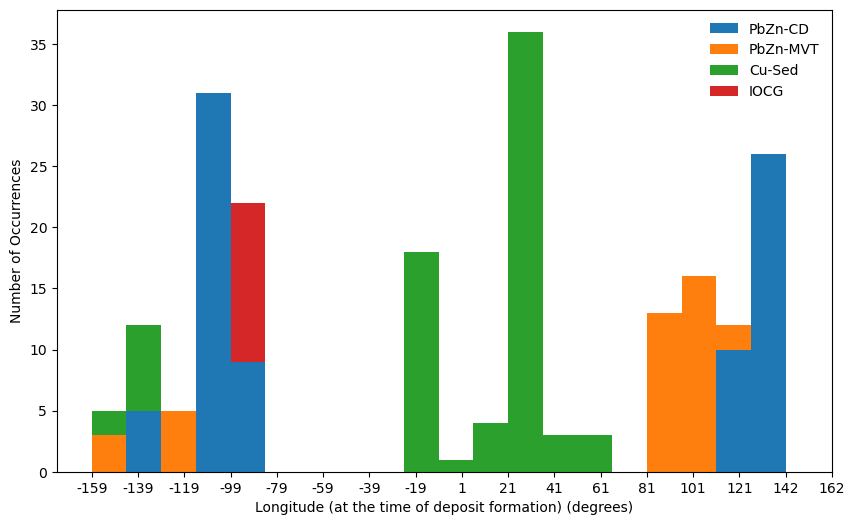

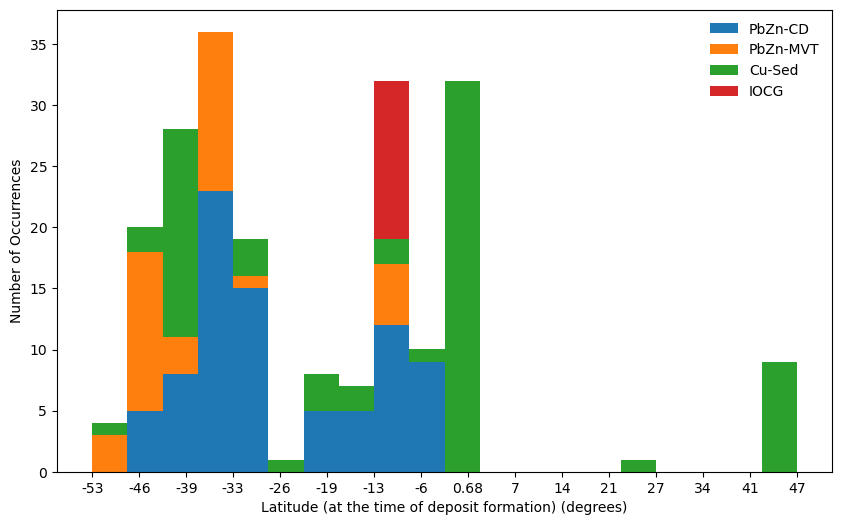

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for rlon and rlat
custom_labels = {
    "rlon": "Longitude (at the time of deposit formation) (degrees)",
    "rlat": "Latitude (at the time of deposit formation) (degrees)"
}

# Loop over rlon and rlat for plotting
for label in ["rlon", "rlat"]:
    # Set the figure size
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Number of Occurrences')

    variable_stack = []
    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Check if the column exists before proceeding
        if label not in df:
            print(f"'{label}' column missing in {type_name}. Skipping...")
            continue

        # Extract the rlon or rlat values, replace inf with nan
        df_column = np.array(df[label])
        df_column = np.where(np.isinf(df_column), np.nan, df_column)
        variable_stack.append(df_column)

        # Calculate percentiles for vmin and vmax, handling NaNs properly
        current_vmin = np.nanpercentile(df_column, 1)
        current_vmax = np.nanpercentile(df_column, 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Ensure that vmin is 0 or lower (for including negative values)
    vmin = min(vmin, 0)

    # Plot the stacked histogram with custom bins
    ax1.hist(variable_stack, bins=20, range=(vmin, vmax), stacked=True, label=types)
    ax1.legend(loc="upper right", frameon=False)

    # Set the step size to create evenly spaced ticks and ensure the ticks start from 0
    step_size = (vmax - vmin) / 15  # Divides the range into 15 equal intervals
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.2f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

    # Show the plot
    plt.show()


## Weighted Histograms

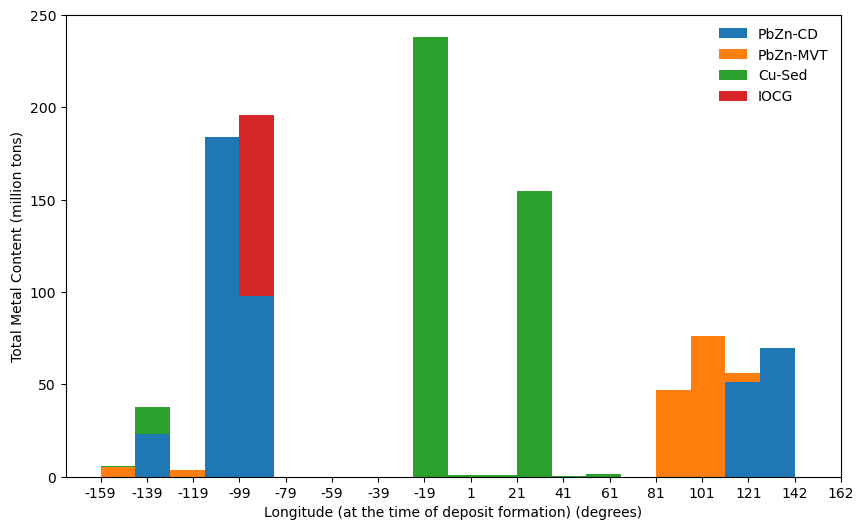

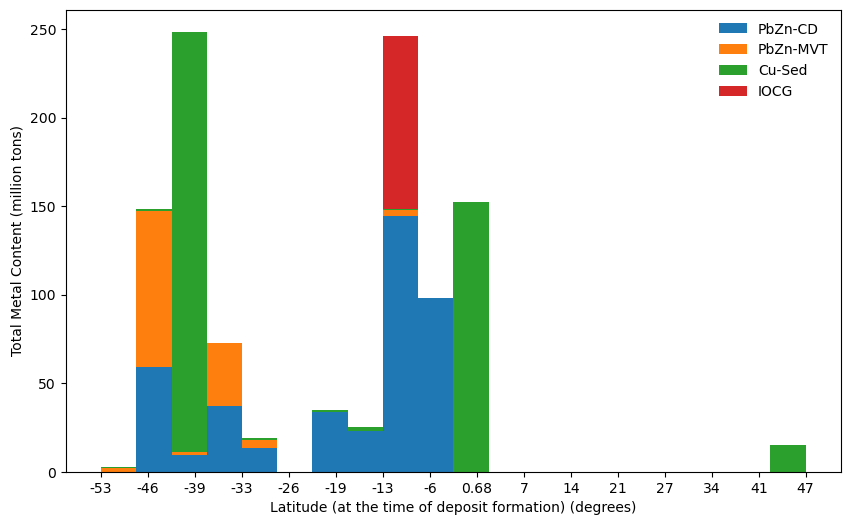

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for rlat and rlon
custom_labels = {
    "rlon": "Longitude (at the time of deposit formation) (degrees)",
    "rlat": "Latitude (at the time of deposit formation) (degrees)"
}

# Loop over the variables for plotting rlat and rlon
for label in ["rlon", "rlat"]:
    # Set the figure size (you can adjust this size)
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Total Metal Content (million tons)')

    variable_stack = []
    weight_stack = []
    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan
        df = df.replace(np.inf, np.nan)

        # Get the variable and weights
        variable = df[label].to_numpy()
        weights = df['TM2'].to_numpy()  # Use TM2 column as weights

        variable_stack.append(variable)
        weight_stack.append(weights)

        # Calculate percentiles for vmin and vmax, handling NaNs properly
        current_vmin = np.nanpercentile(variable, 1)
        current_vmax = np.nanpercentile(variable, 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Ensure that vmin is 0 or lower (for including negative values)
    vmin = min(vmin, 0)

    # Plotting the stacked weighted histogram with custom bins
    ax1.hist(variable_stack, bins=20, range=(vmin, vmax), weights=weight_stack, stacked=True, label=types)
    ax1.legend(loc="upper right", frameon=False)

    # Set the step size to create evenly spaced ticks and ensure the ticks start from 0
    step_size = (vmax - vmin) / 15  # Divides the range into 15 equal intervals
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.2f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

# Show the plot for each iteration
plt.show()


# Checking columns and Export results

In [118]:
# Get the names of the columns
column_names = df.columns
print("The columns in the DataFrame are:")
print(column_names)

The columns in the DataFrame are:
Index(['ANCHOR', 'TIME', 'FILE1', 'RECONFILE1', 'RECONFILE2', 'Type',
       'Deposit', 'Country', 'Lon_', 'Lat_', 'Age__Ga_', 'Age_Uncert',
       'Age_Type', 'Ore__Mt_', 'Cu_grade__', 'Zn_grade__', 'Pb_grade__',
       'Cu__Mt_', 'Zn__Mt_', 'Pb__Mt_', 'TM2', 'Ore_Tonnag', 'References',
       'DIS_Dep_rc', 'PLATEID1', 'Age', 'FEATURE_ID', 'GPGIM_TYPE', 'TOAGE',
       'ID', 'craton_dis', 'craton_az', 'craton_len', 'rift_dis', 'rift_az',
       'rifts_len', 'seg_dis', 'seg_angle', 'NEAR_FID', 'cr_dis', 'geometry',
       'ds_cr_dp', 'cr_len', 'cr_az', 'cr_ve', 'cr_ve_az', 'dp_ve', 'ds_cr_tr',
       'sb_ve', 'tr_adv', 'tr_az', 'tr_cr_an', 'dp_ve_m', 'cr_ve_m',
       'cr_ve_az_m', 'tr_cr_an_m', 'sb_ve_m', 'tr_adv_m', 'dp_ve_g', 'cr_ve_g',
       'cr_ve_az_c', 'tr_cr_an_c', 'sb_ve_g', 'tr_adv_g', 'rlat', 'rlon'],
      dtype='object')


In [119]:
## export all the data in the DataFrame df for each type stored in metal_dict to a single CSV file,
## we can concatenate the DataFrames for each type and then export the combined data to a CSV file

In [120]:
# Create an empty list to collect the data for all types
export_data = []

# Loop through each type and collect all data in the DataFrame
for type_name in types:
    df = metal_dict[type_name]
    
    # Add a column to indicate the type
    df['Type'] = type_name
    
    # Append the data for this type to the export_data list
    export_data.append(df)

# Concatenate all data into a single DataFrame
export_df = pd.concat(export_data, ignore_index=True)

# Export the combined DataFrame to a CSV file
export_df.to_csv('./outputs/segmented_craton_features.csv', index=False)

print("segmented_craton_features.csv")


segmented_craton_features.csv


In [121]:
# export to shp

In [122]:
import geopandas as gpd

# Create an empty list to collect the data for all types
export_data = []

# Loop through each type and collect all data in the DataFrame
for type_name in types:
    df = metal_dict[type_name]
    
    # Add a column to indicate the type
    df['Type'] = type_name
    
    # Append the data for this type to the export_data list
    export_data.append(df)

# Concatenate all data into a single DataFrame
export_df = pd.concat(export_data, ignore_index=True)

# Ensure that the DataFrame has a geometry column
# (assuming your DataFrame already has a 'geometry' column with valid geometries)
gdf = gpd.GeoDataFrame(export_df, geometry='geometry')

# Export the combined GeoDataFrame to a shapefile
gdf.to_file('./outputs/segmented_craton_features.shp', driver='ESRI Shapefile')

print("segmented_craton_features.shp")


segmented_craton_features.shp


# Spearman correlation

In [123]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


## Weighted Spearman Correlation

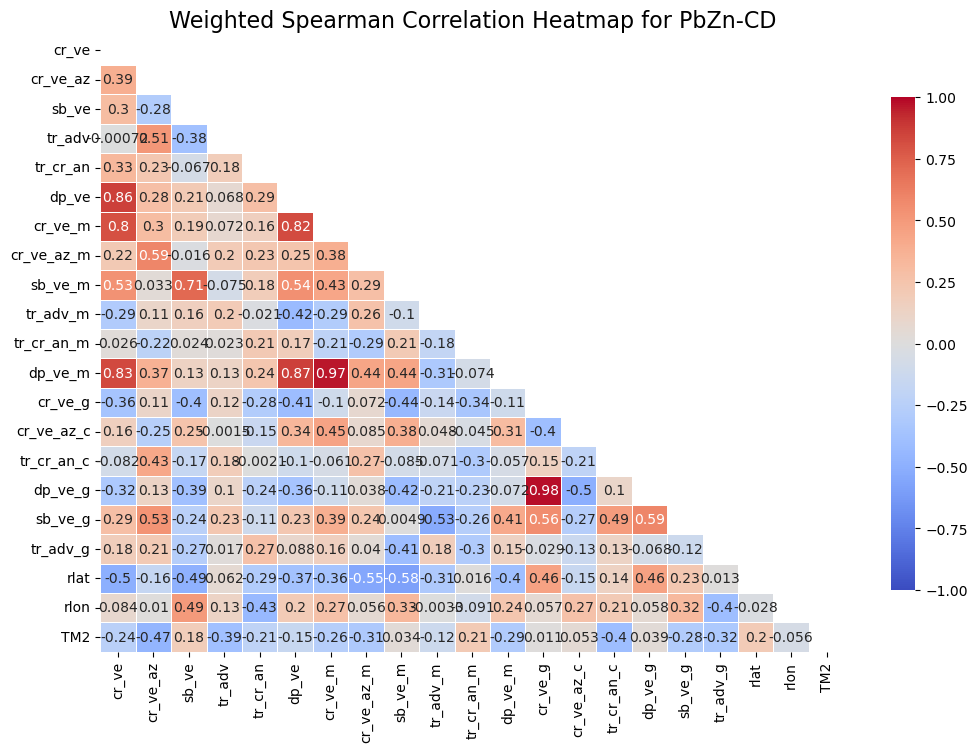

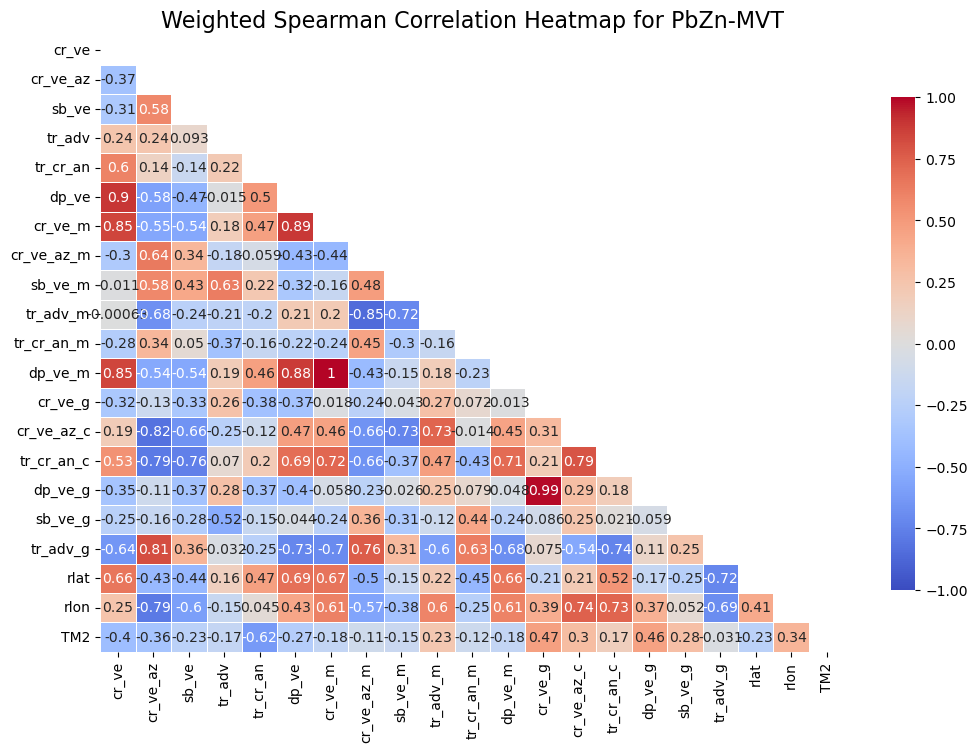

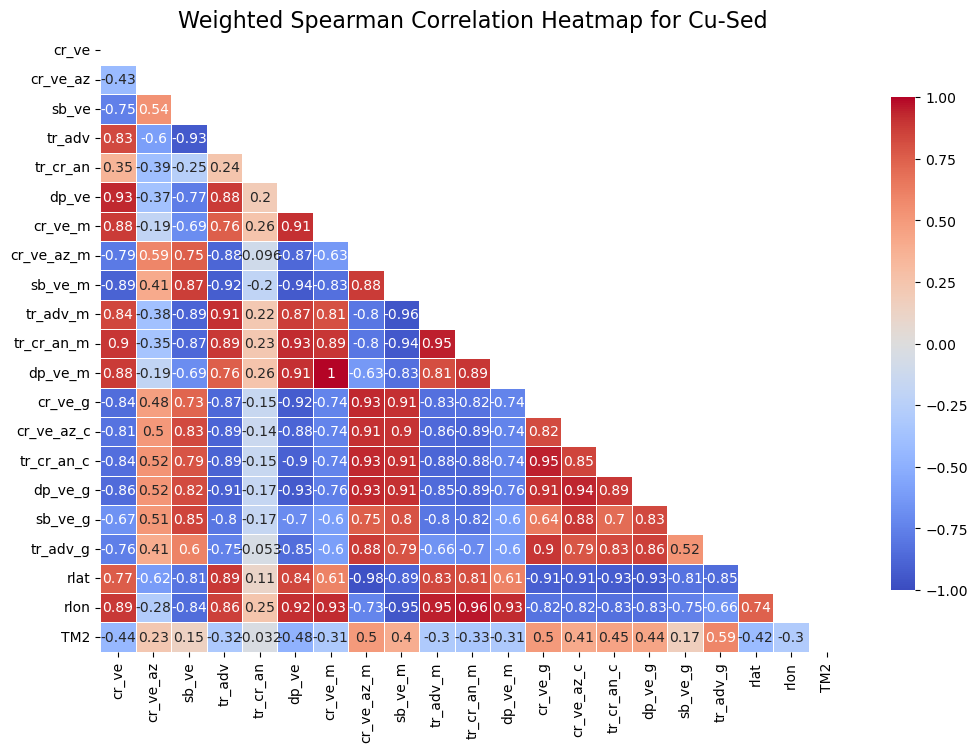

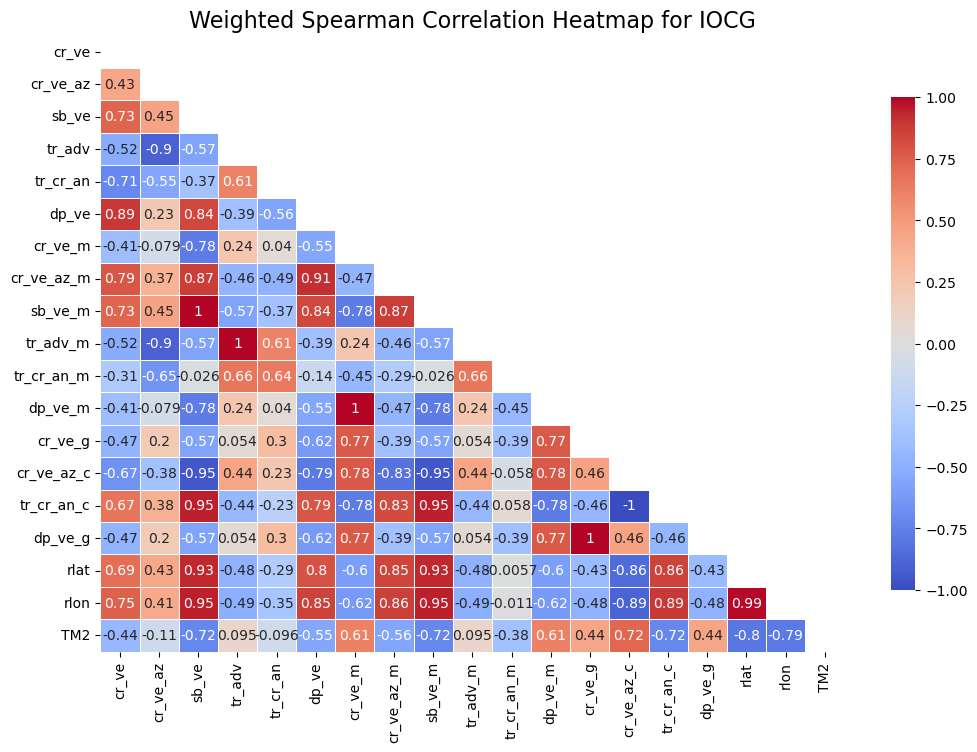

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the combined data from the CSV file
export_df = pd.read_csv('./outputs/segmented_craton_features.csv')

# Define the columns of interest for correlation
columns_of_interest = [
    'cr_ve', 'cr_ve_az', 
    'sb_ve', 'tr_adv', 
    'tr_cr_an', 'dp_ve',
    'cr_ve_m', 'cr_ve_az_m', 
    'sb_ve_m', 'tr_adv_m', 
    'tr_cr_an_m', 'dp_ve_m',
    'cr_ve_g', 'cr_ve_az_c',
    'tr_cr_an_c', 'dp_ve_g',
    'sb_ve_g', 'tr_adv_g',
    'rlat', 'rlon', 'TM2'
]

# Function to compute weighted Spearman correlation
def weighted_spearmanr(x, y, weights):
    # Rank the data
    x_ranked = pd.Series(x).rank()
    y_ranked = pd.Series(y).rank()
    
    # Compute the weighted means of the ranked data
    wx_mean = np.average(x_ranked, weights=weights)
    wy_mean = np.average(y_ranked, weights=weights)
    
    # Compute the weighted covariance
    cov_xy = np.average((x_ranked - wx_mean) * (y_ranked - wy_mean), weights=weights)
    
    # Compute the weighted standard deviations
    wx_std = np.sqrt(np.average((x_ranked - wx_mean)**2, weights=weights))
    wy_std = np.sqrt(np.average((y_ranked - wy_mean)**2, weights=weights))
    
    # Return the weighted Spearman correlation
    return cov_xy / (wx_std * wy_std)

# Group the data by the 'Type' column
types = export_df['Type'].unique()

# Loop over the deposit types in the 'Type' column
for type_name in types:
    df = export_df[export_df['Type'] == type_name]  # Filter data for the current type

    # Handle missing values by dropping rows with NaN in the columns of interest
    df = df.dropna(subset=columns_of_interest)
    
    # Check for columns with zero variance and drop them
    zero_variance_cols = df[columns_of_interest].loc[:, df[columns_of_interest].std() == 0].columns
    df = df.drop(columns=zero_variance_cols, errors='ignore')
    
    # Ensure that all required columns are present and not empty
    remaining_columns = [col for col in columns_of_interest if col in df.columns and df[col].std() != 0]
    
    if len(remaining_columns) < 2:
        print(f"Skipping {type_name} due to insufficient non-zero variance columns.")
        continue
    
    # Extract the weights
    weights = df['TM2'].to_numpy()

    # Compute pairwise weighted Spearman correlations for the remaining columns of interest
    corr_matrix = pd.DataFrame(index=remaining_columns, columns=remaining_columns)

    for col1 in remaining_columns:
        for col2 in remaining_columns:
            # Compute weighted Spearman correlation for each pair
            if col1 != col2:
                corr_matrix.loc[col1, col2] = weighted_spearmanr(df[col1], df[col2], weights)
            else:
                corr_matrix.loc[col1, col2] = 1  # Correlation with itself is always 1

    # Mask the upper triangle of the heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(12, 8))
    plt.title(f"Weighted Spearman Correlation Heatmap for {type_name}", fontsize=16)
    
    # Plot the heatmap with the upper-right half masked
    sns.heatmap(corr_matrix.astype(float), annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, 
                annot_kws={"size": 10}, linewidths=.5, cbar_kws={"shrink": 0.8}, mask=mask)
    
    # Show the heatmap for each deposit type separately
    plt.show()


In [125]:
## columns_of_interest

## Pairplots (No.)

In [126]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Load the combined data from the CSV file
# export_df = pd.read_csv('segmented_craton_features.csv')

# # Define the columns of interest
# columns_of_interest = [
#     'cr_ve_m', 'cr_ve_az_m', 
#     'sb_ve_m', 'tr_adv_m', 
#     'tr_cr_an_m', 'dp_ve_m',
#     'cr_ve_g', 'cr_ve_az_c',
#     'tr_cr_an_c', 'dp_ve_g',
#     'sb_ve_g', 'tr_adv_g',
#     'rlat', 'rlon',
# ]

# # Group the data by the 'Type' column in your combined DataFrame
# types = export_df['Type'].unique()

# # Loop over the deposit types in the 'Type' column
# for type_name in types:
#     # Filter the DataFrame for the current deposit type
#     df_type = export_df[export_df['Type'] == type_name]

#     # Filter the DataFrame to keep only the columns of interest and drop rows with missing values
#     df_clean = df_type[columns_of_interest].dropna()

#     if df_clean.empty:
#         print(f"No data available for {type_name}")
#         continue

#     # Drop columns with zero variance (all values are the same)
#     zero_variance_cols = df_clean.columns[df_clean.nunique() <= 1]
#     df_clean = df_clean.drop(columns=zero_variance_cols)

#     if df_clean.empty:
#         print(f"All columns for {type_name} have zero variance or missing values, skipping.")
#         continue

#     # Create the pairplot with larger dimensions for A0 or A1 size
#     g = sns.pairplot(df_clean, height=1.5, plot_kws={'alpha': 0.6, 's': 120})

#     # Iterate through the axes of the pairplot to hide the upper triangle and adjust labels
#     for i, j in zip(*np.triu_indices_from(g.axes, 1)):
#         g.axes[i, j].set_visible(False)  # Hide the upper triangle plots

#     # Rotate the x-axis and y-axis labels and adjust font size to avoid overlap
#     for ax in g.axes.flatten():
#         ax.set_xticks(ax.get_xticks())  # Set tick positions for x-axis
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)  # Rotate and resize
#         ax.set_yticks(ax.get_yticks())  # Set tick positions for y-axis
#         ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)  # Resize

#     # Set the title for the current deposit type
#     g.fig.suptitle(f"Pairwise Scatter Plots for {type_name}", y=1.02)

#     # Save the plot as a large image in PDF or JPG
#     g.fig.set_size_inches(33.1, 46.8)  # A0 size in inches, adjust to A1 or A2 if needed
#     plt.savefig(f"{type_name}_pairwise_scatter_plots.pdf", format="pdf", dpi=300, bbox_inches='tight')  # Save as PDF
#     plt.savefig(f"{type_name}_pairwise_scatter_plots.jpg", format="jpg", dpi=300, bbox_inches='tight')  # Save as JPG

#     # Close the plot to free up memory
#     plt.close()

#     print(f"Saved pairwise scatter plots for {type_name}.")


## Pairplots (Weighted)

In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the combined data from the CSV file
export_df = pd.read_csv('./outputs/segmented_craton_features.csv')

# Define the columns of interest
columns_of_interest = [
    'cr_ve', 'cr_ve_az', 
    'sb_ve', 'tr_adv', 
    'tr_cr_an', 'dp_ve',
    'cr_ve_m', 'cr_ve_az_m', 
    'sb_ve_m', 'tr_adv_m', 
    'tr_cr_an_m', 'dp_ve_m',
    'cr_ve_g', 'cr_ve_az_c',
    'tr_cr_an_c', 'dp_ve_g',
    'sb_ve_g', 'tr_adv_g',
    'rlat', 'rlon',
]

# Group the data by the 'Type' column in your combined DataFrame
types = export_df['Type'].unique()

# Loop over the deposit types in the 'Type' column
for type_name in types:
    # Filter the DataFrame for the current deposit type
    df_type = export_df[export_df['Type'] == type_name]

    # Filter the DataFrame to keep only the columns of interest and drop rows with missing values
    df_clean = df_type[columns_of_interest + ['TM2']].dropna()

    if df_clean.empty:
        print(f"No data available for {type_name}")
        continue

    # Drop columns with zero variance (all values are the same)
    zero_variance_cols = df_clean.columns[df_clean.nunique() <= 1]
    df_clean = df_clean.drop(columns=zero_variance_cols)

    if df_clean.empty:
        print(f"All columns for {type_name} have zero variance or missing values, skipping.")
        continue

    # Normalize the 'TM2' column for use in point sizes
    df_clean['TM2_normalized'] = (df_clean['TM2'] - df_clean['TM2'].min()) / (df_clean['TM2'].max() - df_clean['TM2'].min())
    df_clean['TM2_normalized'] = df_clean['TM2_normalized'].fillna(1)  # Ensure no NaN values for point sizes
    
    # Custom function to handle weighted scatterplot in pairplot
    def weighted_scatter(x, y, **kwargs):
        sizes = df_clean['TM2_normalized'] * 200  # Multiply to scale sizes
        plt.scatter(x, y, s=sizes, alpha=0.6, edgecolor='k', **kwargs)

    # Create the pairplot with custom scatter function
    g = sns.pairplot(df_clean.drop(columns=['TM2', 'TM2_normalized']), 
                     plot_kws={'s': df_clean['TM2_normalized'] * 200, 'alpha': 0.6, 'edgecolor': 'k'},
                     height=1.5, 
                     markers='o')
    
    # Iterate through the axes of the pairplot to hide the upper triangle and adjust labels
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)  # Hide the upper triangle plots

    # Rotate the x-axis and y-axis labels and adjust font size to avoid overlap
    for ax in g.axes.flatten():
        ax.set_xticks(ax.get_xticks())  # Set tick positions for x-axis
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)  # Rotate and resize
        ax.set_yticks(ax.get_yticks())  # Set tick positions for y-axis
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)  # Resize

    # Set the title for the current deposit type
    g.fig.suptitle(f"Pairwise Scatter Plots for {type_name} (Weighted by TM2)", y=1.02)

    # Save the plot as a large image in PDF or JPG
    g.fig.set_size_inches(33.1, 46.8)  # A0 size in inches, adjust to A1 or A2 if needed
    #plt.savefig(f"{type_name}_pairwise_scatter_plots_weighted_TM2.pdf", format="pdf", dpi=300, bbox_inches='tight')  # Save as PDF
    plt.savefig(f"{type_name}_pairwise_scatter_plots_weighted_TM2.jpg", format="jpg", dpi=300, bbox_inches='tight')  # Save as JPG

    # Close the plot to free up memory
    plt.close()

    print(f"Saved pairwise scatter plots for {type_name} (Weighted by TM2).")


Saved pairwise scatter plots for PbZn-CD (Weighted by TM2).
Saved pairwise scatter plots for PbZn-MVT (Weighted by TM2).
Saved pairwise scatter plots for Cu-Sed (Weighted by TM2).
Saved pairwise scatter plots for IOCG (Weighted by TM2).
